In [473]:
import math
import re
import openai
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import mailbox
import traceback
import yake
import matplotlib.pyplot as plt
from collections import Counter
import pymongo

def getcharsets(msg):
    charsets = set({})
    for c in msg.get_charsets():
        if c is not None:
            charsets.update([c])
    return charsets

def handleerror(errmsg, emailmsg,cs):
    print()
    print(errmsg)
    print("This error occurred while decoding with ",cs," charset.")
    print("These charsets were found in the one email.",getcharsets(emailmsg))
    print("This is the subject:",emailmsg['subject'])
    print("This is the sender:",emailmsg['From'])

def getbodyfromemail(msg):
    body = None
    title = msg['subject']
    #Walk through the parts of the email to find the text body.
    if msg.is_multipart():
        for part in msg.walk():

            # If part is multipart, walk through the subparts.
            if part.is_multipart():

                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        # Get the subpart payload (i.e the message body)
                        body = subpart.get_payload(decode=True)
                        #charset = subpart.get_charset()

            # Part isn't multipart so get the email body
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
                #charset = part.get_charset()

    # If this isn't a multi-part message then get the payload (i.e the message body)
    elif msg.get_content_type() == 'text/plain':
        body = msg.get_payload(decode=True)

   # No checking done to match the charset with the correct part.
    for charset in getcharsets(msg):
        try:
            body = body.decode(charset)
        except UnicodeDecodeError:
            handleerror("UnicodeDecodeError: encountered.",msg,charset)
        except AttributeError:
             handleerror("AttributeError: encountered" ,msg,charset)
    return [body,title]

In [84]:
openai.api_key = "my-secret-key"

topicList = []
durationList = []
institutionList = []
supervisorList = []
salaryList = []
keywords = []

topicSearch = "- *Job topic *:|- *Job Topic *:|- *Topic *:|Topic *:|Job topic *:|Job Topic *:|Job *[0-9] *:|Job *\([0-9]\) *:"
durationSearch = "- *Duration *:|Duration *:|- *Job duration *:|Job duration *:"
institutionSearch = "- *Institution *:|Institution *:"
supervisorSearch = "- *Supervisor *:|- *Supervisor\(s\) *:|Supervisor *:|Supervisor\(s\) *:"
salarySearch = "- *Salary *:|- *Salary/Stipend *:|Salary *:|Salary/Stipend *:"
nextJobSearch = "Job *[0-9] *:|Job *\([0-9]\) *:"

counterAll = 0
counter = 0
failCount = 0
sourceFileTest = r"C:\Users\Adham Hesham\Desktop\ML-news\ml-news2.mbox"
sourceFile = r"C:\Users\Adham Hesham\Desktop\ML-news\allEmails.mbox"
for thisemail in mailbox.mbox(sourceFile):
    counterAll += 1
    body, title = getbodyfromemail(thisemail)
    if len(re.findall(r"(?=.*^((?!\[job\]).)*$)(?=.*^((?!\[jobs\]).)*$)(?=.*^((?!fellowship).)*$)(?=.*phd)", title.lower())) > 0:
        counter += 1
        try:
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo-0301",
                messages=[
                    {"role": "system", "content": "I will present you with the content of email messages advertising events or positions in the area of machine learning and you must extract certain information from them and nothing more."},
                    {"role": "user", "content": "Return  job topic, duration, institution, supervisor and salary from the following job advert email formatted as (variable): (information) with no extra notes and if there are multiple jobs then seperate each job's subject's information under the header Job(number): and if there are missing information about a variable then still write the variable with n/a as the information" },
                    {"role": "user", "content": body}
                ],
                temperature=0,
                max_tokens=450
            )
            response = response["choices"][0]["message"]["content"]

            print(response, "\n-------\n")
            noOfads = re.findall(nextJobSearch, response)
            if len(noOfads) > 1:
                if noOfads[0] == noOfads[1]:
                    noOfads = noOfads[0]
            print("Number of ads: ",len(noOfads))
            print("Ad number: ",counter)

            for i in range(len(noOfads)):
                print("Processing ad: ",i,"\n-------\n")
                if i != (len(noOfads) - 1):
                    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
                    duration = [re.search(durationSearch, response).end() , re.search(institutionSearch, response).start()]
                    instritution = [re.search(institutionSearch, response).end() , re.search(supervisorSearch, response).start()]
                    supervisor = [re.search(supervisorSearch, response).end() , re.search(salarySearch, response).start()]
                    salary = [re.search(salarySearch, response).end() , re.search(nextJobSearch, response).start()]
                    topicList.append(
                        re.sub(topicSearch + "|:|-", "",
                        response[topic[0] : topic[1]]
                        )
                    )
                    durationList.append(response[duration[0] : duration[1]])
                    institutionList.append(response[instritution[0] : instritution[1]])
                    supervisorList.append(response[supervisor[0] : supervisor[1]])
                    response = re.sub(nextJobSearch,"", response,1)
                    salaryList.append(response[salary[0] : salary[1]])
                    if len(re.findall(nextJobSearch, response)) == len(re.findall(topicSearch, response)):
                        response = re.sub(topicSearch + "|" + durationSearch + "|" + institutionSearch + "|" + supervisorSearch + "|" + salarySearch, "", response, 4)
                    else:
                        response = re.sub(topicSearch + "|" + durationSearch + "|" + institutionSearch + "|" + supervisorSearch + "|" + salarySearch, "", response, 5)
                else:
                    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
                    duration = [re.search(durationSearch, response).end() , re.search(institutionSearch, response).start()]
                    instritution = [re.search(institutionSearch, response).end() , re.search(supervisorSearch, response).start()]
                    supervisor = [re.search(supervisorSearch, response).end() , re.search(salarySearch, response).start()]
                    salary = re.search(salarySearch, response).end()
                    topicList.append(
                        re.sub(topicSearch + "|:|-", "",
                               response[topic[0] : topic[1]]
                               )
                    )
                    durationList.append(response[duration[0] : duration[1]])
                    institutionList.append(response[instritution[0] : instritution[1]])
                    supervisorList.append(response[supervisor[0] : supervisor[1]])
                    salaryList.append(response[salary:])

            kw_extractor = yake.KeywordExtractor(lan="en", n=3, dedupLim= 1/(1+math.exp(-1.5*(len(noOfads))+4)), top=len(noOfads) * 5, features=None)
            keywords.append(kw_extractor.extract_keywords(body))
        except Exception:
            print("Email number ", counter, " failed to parse.")
            print("\n-------\n")
            traceback.print_exc()
            failCount += 1
print("Total number of emails in file: ", counterAll)
print("Number of job emails: ", counter)
print("Number of failed parsings: ", failCount)



Job1: PhD student forum on machine learning and knowledge discovery
- Job topic: PhD student forum on machine learning and knowledge discovery
- Duration: September 18-22, 2023
- Institution: ECML PKDD in Turin, Italy
- Supervisor: Yllka Velaj (University of Vienna), Matteo Riondato (Amherst College)
- Salary: n/a 
-------

Number of ads:  1
Ad number:  1
Processing ad:  0 
-------

Job1: QUB's LINAS Interdisciplinary PhD programme
- Job topic: AI and social sciences
- Duration: not mentioned
- Institution: QUB
- Supervisor: Muiris MacCarthaigh
- Salary: stipend and fees for UK/IRL candidates, stipend and part-fee-contribution for others

Job2: Exploratory PhD project on Algorithms for Platform Co-operativism
- Job topic: Algorithms for Platform Co-operativism
- Duration: not mentioned
- Institution: QUB
- Supervisor: Muiris MacCarthaigh
- Salary: stipend and fees for UK/IRL candidates, stipend and part-fee-contribution for others 
-------

Number of ads:  2
Ad number:  2
Processing ad

Job(1): PhD research fellow in artificial intelligence and machine learning tools for UAV communication
Duration: n/a
Institution: Autonomous Systems Laboratory, University of Agder, Norway
Supervisor: n/a
Salary: n/a 
-------

Number of ads:  1
Ad number:  22
Processing ad:  0 
-------

Job 1: 
- Job topic: PhD position in NLP
- Duration: 3 years
- Institution: Bielefeld University
- Supervisor: Dr. Steffen Eger and Dr. Ole Pütz (Prof. Dr. Philipp Cimiano)
- Salary: 100% TV-L E13
- Application deadline: Feb 23, 2023

Note: The email advertises only one job position. 
-------

Number of ads:  1
Ad number:  23
Processing ad:  0 
-------

Job 1: 
- Job topic: PhD student in a project dealing with anonymization and synthesis of click paths and behavior on the web
- Duration: n/a
- Institution: Leuphana University
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  1
Ad number:  24
Processing ad:  0 
-------

Job 1: 
- Job topic: Doctoral Fellowship Program in AI
- Duration: 3 years,

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: Learning disentangled representations to achieve responsible and transparent AI
- Duration: 4 years (1 year MRes + 3 years PhD)
- Institution: University of Bath, UK
- Supervisor: n/a
- Salary: Fully funded

Note: Starting date is expected on October 2, 2023. 
-------

Number of ads:  1
Ad number:  28
Processing ad:  0 
-------

Job(1): Ph.D. position
Duration: n/a
Institution: KTH - Royal Institute of Technology
Supervisor: Prof. Mikael Johansson
Salary: n/a 
-------

Number of ads:  1
Ad number:  29
Processing ad:  0 
-------

Job(1): 
- Job topic: PhD position in reinforcement learning for public health decision making 
- Duration: n/a 
- Institution: AI lab of the VUB in Brussels (Belgium) 
- Supervisor: n/a 
- Salary: n/a 
-------

Number of ads:  1
Ad number:  30
Processing ad:  0 
-------

Job 1: PhD position in cellular biology and machine learning
Duration: n/a
Institution: Stockholm University
Supervisor: Associate Professor Juliette Griffie
Salary: n/a 


Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: "Robust Learning of Sparse Representations in Neural Networks" 
- Duration: 4 years 
- Institution: University of Groningen 
- Supervisor: George Azzopardi 
- Salary: Fully funded 

Job 2: 
- Job topic: "Robust Learning of Sparse Representations in Neural Networks" 
- Duration: 4 years 
- Institution: University of Groningen 
- Supervisor: Michael Biehl 
- Salary: Fully funded 
-------

Number of ads:  2
Ad number:  37
Processing ad:  0 
-------

Processing ad:  1 
-------

Job: PhD in multi-modal learning for geo-localisation of reading-for-pleasure books
Duration: 36 months
Institution: University of Southampton
Supervisor: Shoaib Jameel
Salary: n/a 
-------

Number of ads:  0
Ad number:  38
Job1: Develop human-AI interactive models for accountable drought predictions.
Duration: n/a
Institution: University of South Australia, Adelaide, Australia
Supervisor: n/a
Salary: International tuition fees and living allowance
Deadline: 23 Jan 2023 
-------

Number of ads: 

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): Ph.D. Research Fellowship in Machine Learning
Duration: n/a
Institution: University of Oslo
Supervisor: Ali Ramezani-Kebrya
Salary: 501 200 – 544 400 NOK/year (50.2k – 54k USD/year) 
-------

Number of ads:  1
Ad number:  48
Processing ad:  0 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'utf-8'}
This is the subject: Re: [ML-news] Prospective PhD position at your lab
This is the sender: Laura Dietz <dietz@cs.unh.edu>
Email number  49  failed to parse.

-------



Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 36, in <cell line: 30>
    response = openai.ChatCompletion.create(
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\openai\api_resources\chat_completion.py", line 25, in create
    return super().create(*args, **kwargs)
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\openai\api_resources\abstract\engine_api_resource.py", line 153, in create
    response, _, api_key = requestor.request(
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\openai\api_requestor.py", line 226, in request
    resp, got_stream = self._interpret_response(result, stream)
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\openai\api_requestor.py", line 619, in _interpret_response
    self._interpret_response_line(
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\o

Job 1: PhD studentship position
- Job topic: Natural Language Processing, Deep Learning, and Machine learning algorithms
- Duration: n/a
- Institution: n/a
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  1
Ad number:  50
Processing ad:  0 
-------

Job 1: WiML Mentorship Program
- Job topic: Mentorship program for Ph.D. applicants
- Duration: 6 months (September 19th to March 3rd)
- Institution: WiML Workshop
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  1
Ad number:  51
Processing ad:  0 
-------

Job(1): 
- Topic: Ph.D. scholarship in social and cognitive robotics
- Duration: 3.5 years
- Institution: UNSW Sydney
- Supervisor: Dr. Francisco Cruz
- Salary: AUD $28,854 per annum (2022 rate), tuition fees, and overseas student health cover (OSHC) 
-------

Number of ads:  1
Ad number:  52
Processing ad:  0 
-------

Job(1): 
Topic: PhD Studentship in Clinical Informatics
Duration: 3 years
Institution: UCL Great Ormond Street Institute of Child Health (GOS ICH)
Super

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: PhD position on neuro-symbolic modelling of music
- Duration: Not specified
- Institution: Durham University (UK)
- Supervisor: Robert Lieck
- Salary: Funded position

Note: The email provides detailed information about the job requirements, responsibilities, and benefits. The preferred start date is October 2022, and applications are accepted on a rolling basis. The email also encourages applications from underrepresented groups. 
-------

Number of ads:  1
Ad number:  67
Processing ad:  0 
-------

Job 1: 
Topic: PhD student scholarships in sentiment analysis from text, audio or video
Duration: n/a
Institution: University of Queensland
Supervisor: i.chaturvedi@uq.edu.au
Salary: n/a 
-------

Number of ads:  1
Ad number:  68
Processing ad:  0 
-------

Job(1): PhD Symposium at The Web Conference 2023
- Job topic: PhD Symposium
- Duration: April 30 - May 4, 2023
- Institution: The Web Conference 2023
- Supervisor: Yizhou Sun, Yuxiao Dong, Mayank Kejriwal
- Salary: 

Job 1: 
- Job topic: Multimodal fair learning 
- Duration: n/a 
- Institution: Aix-Marseille University 
- Supervisor: Dr. Hachem Kadri 
- Salary: n/a 
-------

Number of ads:  1
Ad number:  87
Processing ad:  0 
-------

Job(1): PhD position
Duration: n/a
Institution: LIFAT laboratory of Tours in France
Supervisor(s): Hugo Raguet, Julien Mille, and Romain Raveaux
Salary: about 1600 euros 
-------

Number of ads:  1
Ad number:  88
Processing ad:  0 
-------

Job(1): PhD student in reinforcement learning and decision making under uncertainty
- Job topic: reinforcement learning and decision making under uncertainty
- Duration: 4 years
- Institution: University of Neuchatel, Switzerland
- Supervisor: Christos Dimitrakakis
- Salary: fully funded with approximately 25% of the time as a teaching assistant

Application Information:
- Starting date: 1 September 2022 or soon afterwards
- Application deadline: 31 May 2022 
-------

Number of ads:  1
Ad number:  89
Processing ad:  0 
-------

Job

Job 1: 
- Job topic: Data-driven Vulnerability Analysis for Critical Infrastructures
- Duration: n/a
- Institution: Uppsala University
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  1
Ad number:  105
Processing ad:  0 
-------

Job(1): 
- Job topic: Ph.D. position in machine learning algorithms, systems, and architectures
- Duration: n/a
- Institution: KTH - Royal Institute of Technology
- Supervisor: Prof. Mikael Johansson
- Salary: n/a 
-------

Number of ads:  1
Ad number:  106
Processing ad:  0 
-------

Job 1: 
Topic: PhD and Postdoc positions in Time-to-Event Modelling
Duration: n/a
Institution: University of Kaiserslautern and German Research Centre for Artificial Intelligence
Supervisor: Sebastian Vollmer
Salary: n/a 
-------

Number of ads:  1
Ad number:  107
Processing ad:  0 
-------

Job(1): 
- Topic: PhD position in deep learning and numerical optimization
- Duration: n/a
- Institution: Uppsala University, Sweden
- Supervisor: Prashant Singh
- Salary: n/a 
-----

Job 1: 
Topic: Automatic grading of Spine MRI
Duration: n/a
Institution: University of Oulu
Supervisor: Aleksei Tiulpin, PhD
Salary: n/a 
-------

Number of ads:  1
Ad number:  128
Processing ad:  0 
-------

Job 1: 
- Job topic: PhD position 
- Duration: n/a 
- Institution: SCK-CEN, Mol, Belgium 
- Supervisor: n/a 
- Salary: n/a 

Job 2: 
- Job topic: PhD position 
- Duration: n/a 
- Institution: IDLab, Ghent University - imec, Belgium 
- Supervisor: n/a 
- Salary: n/a 
-------

Number of ads:  2
Ad number:  129
Processing ad:  0 
-------

Processing ad:  1 
-------

Job 1: 
- Job topic: PhD position 
- Duration: Not mentioned 
- Institution: SCK-CEN, Mol, Belgium 
- Supervisor: Not mentioned 
- Salary: Not mentioned 

Job 2: 
- Job topic: PhD position 
- Duration: Not mentioned 
- Institution: IDLab, Ghent University - imec, Belgium 
- Supervisor: Not mentioned 
- Salary: Not mentioned 
-------

Number of ads:  2
Ad number:  130
Processing ad:  0 
-------

Processing ad:  1 
-------


Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 59, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job1: PhD Position in Human-In-the-Loop AI
- Job topic: Human-In-the-Loop AI
- Duration: 4-year contract
- Institution: TU Delft
- Supervisor: Dr. Jie Yang
- Salary: € 2395 per month in the first year to € 3061 in the fourth year 
-------

Number of ads:  1
Ad number:  144
Processing ad:  0 
-------

Job(1): 
Topic: PhD student position in Robot Learning
Duration: 1+3 years
Institution: Aalto University
Supervisor: Assistant Professor Joni Pajarinen
Salary: Approximately 2500 EUR/month 
-------

Number of ads:  1
Ad number:  145
Processing ad:  0 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'us-ascii', 'utf-8'}
This is the subject: [ML-news] abt ISMSI22
This is the sender: Suash Deb <suashdeb@gmail.com>
Job(1): 
- Job topic: PhD Position in Machine Learning (Federated Learning)
- Duration: 3 years
- Institution: University of Mons - Department of Computer Science - Belgium
- Supervisor: Souh

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: PhD position in reinforcement learning and decision making
- Duration: Not specified
- Institution: University of Neuchatel, Switzerland
- Supervisor: Christos Dimitrakakis
- Salary: Not specified 
-------

Number of ads:  1
Ad number:  153
Processing ad:  0 
-------

Job 1: 
Topic: PhD studentship in Interactive Artificial Intelligence
Duration: 4 years (1 year foundational topics + 3-year research project)
Institution: University of Bristol, UK
Supervisor: One of the 60 academics in the supervisory network
Salary: Fully funded

Note: No specific salary information is provided. 
-------

Number of ads:  1
Ad number:  154
Processing ad:  0 
-------

Job(1): 
Topic: PhD positions in reinforcement learning and other topics
Duration: n/a
Institution: Applied Artificial Intelligence Institute, Deakin University (Geelong campus), Australia
Supervisor: Thommen George Karimpanalgeorge or Sunil Gupta
Salary: Stipend of ~A$27000 per annum, relocation allowance, overseas hea

Job(1): 
Topic: Causal modeling for understanding of the energy demand on the residential and service sectors
Duration: PhD
Institution: University of Deusto, Bilbao (Spain)
Supervisor: Cruz E. Borges and Diego Casado-Mansilla
Salary: n/a 
-------

Number of ads:  1
Ad number:  171
Processing ad:  0 
-------

Job 1: 
- Job topic: PhD position in data analytics and machine learning approaches for the deployment and proactive optimization of 5G and multi-RAT networks
- Duration: 36 months (18-month internship in a company and 18 months in academic institute)
- Institution: PoliTo and CNR
- Supervisor: n/a
- Salary: 
  - Living allowance of 40,966.56 €/year, that will be paid in monthly installments (3,413.88 €/month)
  - Mobility allowance of 7,200.00 €/year (600 €/month)
  - Family allowance of 500.00€/month (only in case the winner is married or has a similar legal situation)

Note: The official call is posted in https://bandi.urp.cnr.it/assegni/faces/pubblica/RisultatoCercaAssegniPubb

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): 
Topic: PhD studentships in Foundational AI CDT
Duration: Not specified
Institution: University College London
Supervisor: Not specified
Salary: Funding for PhD students in the UK does unfortunately take residence/nationality into account. This program has more flexibility for students who apply earlier.

Job(2):
Topic: Other UCL PhD studentships in ML
Duration: Not specified
Institution: University College London
Supervisor: Not specified
Salary: It depends on isolated funding within a given research group, projects, scholarships, sponsors etc. Like the Foundational AI CDT, or even more so, UK (or maybe EU - we shall see) applicants are easier to fund because of national rules.

Job(3):
Topic: Research team of Gabriel J. Brostow
Duration: Not specified
Institution: University College London
Supervisor: Gabriel J. Brostow
Salary: Not specified 
-------

Number of ads:  3
Ad number:  181
Processing ad:  0 
-------

Processing ad:  1 
-------

Processing ad:  2 
-------

Job(1): 

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): 
- Topic: PhD studentships in Interactive Artificial Intelligence
- Duration: 4 years (1 year taught, 3 years research)
- Institution: University of Bristol
- Supervisor: One of the 75+ academics in the supervisory network
- Salary: Fully-funded

Job(2): n/a 
-------

Number of ads:  2
Ad number:  185
Processing ad:  0 
-------

Processing ad:  1 
-------

Email number  185  failed to parse.

-------



Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): 
Topic: PhD studentships in Interactive Artificial Intelligence
Duration: 3 years
Institution: University of Bristol
Supervisor: One of the 60 academics in the supervisory network
Salary: Fully-funded

Job(2):
Topic: n/a
Duration: n/a
Institution: n/a
Supervisor: n/a
Salary: n/a

Note: There is only one job advertised in this email. 
-------

Number of ads:  2
Ad number:  186
Processing ad:  0 
-------

Processing ad:  1 
-------

Job1: 
- Job topic: Postdoc/PhD and developer posts
- Duration: n/a
- Institution: Institute of Digital Games, University of Malta
- Supervisor: Georgios N. Yannakakis
- Salary: n/a 
-------

Number of ads:  1
Ad number:  187
Processing ad:  0 
-------

Job(1): Postdoc and PhD positions
Topic: Software engineering, systems science, distributed systems, virtualized HPC systems, systems monitoring, dependency, data science, distributed machine learning, sustainable computing, and environmental informatics.
Duration: n/a
Institution: Institute for Inform

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 59, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: PhD position in Explainable Natural Language Processing
- Duration: Not specified
- Institution: University of Copenhagen
- Supervisor: Isabelle Augenstein
- Salary: Not specified 
-------

Number of ads:  1
Ad number:  201
Processing ad:  0 
-------

Job(1): Postdoctoral positions
Duration: n/a
Institution: University of Wisconsin-Madison
Supervisor: Professor Moo K. Chung
Salary: n/a 
-------

Number of ads:  1
Ad number:  202
Processing ad:  0 
-------

Job 1: 
- Job topic: Neural Architectures for Speech Technology
- Duration: n/a
- Institution: Idiap Research Institute
- Supervisor: n/a
- Salary: quite generous salaries

Job 2:
- Job topic: Speech recognition and natural language processing for digital interviews
- Duration: n/a
- Institution: Idiap Research Institute
- Supervisor: n/a
- Salary: quite generous salaries 
-------

Number of ads:  2
Ad number:  203
Processing ad:  0 
-------

Processing ad:  1 
-------


AttributeError: encountered
This error occ

Job 1: 
- Job topic: PhD in Natural Language Processing
- Duration: initially 6 months (probatory period) renewable until the end of the PhD (max 4 years)
- Institution: INESC TEC, Porto, Portugal
- Supervisor: Alípio Jorge
- Salary: €989,70 (MSC) monthly grant and PhD fees covered

Job 2:
- Job topic: n/a
- Duration: n/a
- Institution: n/a
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  2
Ad number:  219
Processing ad:  0 
-------

Processing ad:  1 
-------

Job 1: PhD positions in Computer Science and Artificial Intelligence
Duration: n/a
Institution: University of Trento
Supervisor: Prof. Marco Roveri
Salary: €16.290,00 (annual gross amount) 
-------

Number of ads:  1
Ad number:  220
Processing ad:  0 
-------

Job 1: PhD Consortium Proposals for DASFAA 2021
- Job topic: PhD Consortium Proposals
- Duration: Not specified
- Institution: DASFAA 2021
- Supervisor: PhD Consortium Committee
- Salary: Not applicable 
-------

Number of ads:  1
Ad number:  221
Processing ad:  0

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 59, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'end'


Job1: PhD position
Topic: Machine learning techniques to develop and enhance computational models of the spinal cord
Duration: n/a
Institution: Swiss Federal Institute of Technology (EPFL)
Supervisor: Prof. Gregoire Courtine
Salary: Fully funded PhD position, with salaries at EPFL ranking the highest in the world. 
-------

Number of ads:  1
Ad number:  233
Processing ad:  0 
-------

Job(1): PhD students
Duration: n/a
Institution: Concordia University and Mila
Supervisor: Eugene Belilovsky
Salary: n/a

Topics: continual learning, few-shot learning, vision and language (e.g. image captioning, VQA), distributed deep learning. 
-------

Number of ads:  1
Ad number:  234
Processing ad:  0 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'utf-8'}
This is the subject: [ML-news] PhD studentship in Big Data, Machine Learning and Galactic
 Star Formation
This is the sender: =?UTF-8?Q?Fran=c3=a7ois-Xavie

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: PhD in Statistics and Computer Science
- Job topic: PhD in Statistics and Computer Science
- Duration: 4 years
- Institution: Bocconi University
- Supervisor: Antonio Lijoi (antonio.lijoi@unibocconi.it)
- Salary: 
  - 20.280 euro per annum in the 1st and 2nd year
  - 15.343 euro per annum in the 3rd and 4th year 
-------

Number of ads:  1
Ad number:  248
Processing ad:  0 
-------

Job 1: 
- Topic: Machine Learning models for Forensic Genetics.
- Duration: n/a
- Institution: Laboratory of Structural Bioinformatics and Computational Biology, Institute of Informatics, Federal University of Rio Grande do Sul, Porto Alegre, Brazil
- Supervisor: Prof. Dorn (mdorn@inf.ufrgs.br)
- Salary: n/a

Job 2:
- Topic: Machine Learning  for System Biology, Mutation Detection, and/or Gene Expression Analysis
- Duration: n/a
- Institution: Laboratory of Structural Bioinformatics and Computational Biology, Institute of Informatics, Federal University of Rio Grande do Sul, Porto Alegre, Brazil
- Su

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Program Files\Python39\lib\http\client.py", line 1377, in getresponse
    response.begin()
  File "C:\Program Files\Python39\lib\http\client.py", line 320, in begin
    version, status, reason = self._read_status()
  File "C:\Program Files\Python39\lib\http\client.py", line 281, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Program Files\Python39\lib\socket.py", line 7

Email number  257  failed to parse.

-------



Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\Program Files\Python39\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "C:\Users\Adham Hesham\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 386, in 

Job 1: 
Topic: PhD position in differential and probabilistic programming
Duration: n/a
Institution: Utrecht University
Supervisor: Matthijs Vákár
Salary: n/a 
-------

Number of ads:  1
Ad number:  258
Processing ad:  0 
-------

Job 1: PhD Position Joint Doctoral Program NITech Japan
- Job topic: PhD position in Artificial Intelligence and Machine Learning
- Duration: Not specified
- Institution: Nagoya Institute of Technology (NITech) Japan, and University of Wollongong (UOW) Australia
- Supervisor: Dr. Ahmed Moustafa
- Salary: Competitive compensation 
-------

Number of ads:  1
Ad number:  259
Processing ad:  0 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'utf-8'}
This is the subject: [ML-news] [jobs] Lecturer or Senior Lecturer in Computer Science (Robotics)
This is the sender: <dr.a.behera@gmail.com>
Job(1): 
Topic: PhD research studentships in Computer Science, Engineering or Mathema

Job(1): 
- Job topic: Natural Language Processing /Machine Learning/Deep Learning for CyberSecurity
- Duration: n/a
- Institution: RÍOMH Research Group, Cork Institute of technology, Cork, Ireland
- Supervisor: Mohammed Hasanuzzaman
- Salary: Fully funded PhD positions

Basic Eligibility Criteria:
- Applicants must hold at least a 2.1 honours undergraduate degree in either Computer Science, Computer Engineering, Electrical and Electronic Engineering, Psychology, Social Science.
- Non-native English speakers are required to hold a valid IELTS (or equivalent) certificate demonstrating at least a score of 6.5 overall with a score of not less than 6 in all parts.

Deadline: Friday, 21st February, 2020 at 5pm

Job(1) Potential Topics:
1. Automatic Threat Intelligence Extraction from Unstructured Sources
2. Source Code Vulnerability Analysis
3. Phishing Identification in social Media and other platforms
4. Vulnerability Exploit Prediction
5. Cyber Event Forecasting by Discovering Signals fro

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: PhD Position Joint Doctoral Program NITech Japan
- Job topic: PhD position in Artificial Intelligence and Machine Learning
- Duration: Not specified
- Institution: Nagoya Institute of Technology (NITech) Japan, and University of Wollongong (UOW) Australia
- Supervisor: Prof. Takayuki Ito, Email ito.takayuki@nitech.ac.jp and Dr. Ahmed Moustafa, Email ahmed@nitech.ac.jp
- Salary: Competitive compensation 
-------

Number of ads:  1
Ad number:  276
Processing ad:  0 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'us-ascii', 'utf-8'}
This is the subject: [folli] Job opening: Computational Linguist at the South African
 Centre for Digital Language Resources (SADiLaR)
This is the sender: "Menno Van Zaanen" <Menno.VanZaanen@nwu.ac.za>
Job 1: 
- Topic: Bioinformatics/Computational Biology, Machine Learning (ML)/Artificial Intelligence (AI), Biomarker Discovery, Stratified/Personalized Medicine 

Job 1: 
Topic: Data privacy for big data / machine learning
Duration: 48 months
Institution: Hamilton Institute, Maynooth University, Ireland
Supervisor: Prof. Vicenc Torra
Salary: Annual stipend of 18,500 EUR + 100% of tuition fees (EU students)

Requirements:
- Degree in computer science/engineering, mathematics, or related areas. 
-------

Number of ads:  1
Ad number:  287
Processing ad:  0 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'us-ascii', 'utf-8'}
This is the subject: [folli] 2nd CfP First workshop on Resources for African Indigenous
 Language (RAIL) @ LREC 2020
This is the sender: "Menno Van Zaanen" <Menno.VanZaanen@nwu.ac.za>
Job(1): PhD candidates in the area of machine learning
Duration: n/a
Institution: University of California San Diego
Supervisor: Pengtao Xie
Salary: Fully-funded

Note: No specific information about the duration of the job is provided. 
-------

Number of a

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: PhD student position
Topic: Deep learning, computer vision, bio-mechanical modelling and prediction of knee osteoarthritis progression
Duration: n/a
Institution: Research Unit of Medical Imaging, Physics and Technology / University of Oulu, Finland
Supervisor: n/a
Salary: n/a 
-------

Number of ads:  1
Ad number:  304
Processing ad:  0 
-------

Job(1): Biometrics, Human Behavior, Privacy, Security, HCI, Machine Learning
Duration: n/a
Institution: Universidad Autonoma de Madrid, Spain
Supervisor: n/a
Salary: ca. 50k EUR/year + generous funding for research activities.

Job(2): n/a
Duration: n/a
Institution: n/a
Supervisor: n/a
Salary: n/a

Essential Criteria:
- Master’s Degree in Electrical Engineering, Computer Science or Mathematics.
- Solid understanding of Pattern Recognition, Machine Learning, and Deep Learning.
- Good programming skills.
- Proactive, curiosity-driven, and committed to deliver by deadlines.
- Availability to travel for technical and scientific conferences,

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 59, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
Topic: PhD candidate in Computer Science with interest in NLP
Duration: Not specified
Institution: TU Wien (Technische Universität Wien, Austria)
Supervisor: Not specified
Salary: Funding for the PhD research is secured through a currently running research project

Requirements:
- Computer Science MSc.
- Master of Arts is admissible only with Language Technology or Computational Linguistics as the main field of study
- NLP basic knowledge or more
- Annotation experience/Corpus design
- Good to know: Distributional Semantics
- Good communication and presentation skills in English 
-------

Number of ads:  1
Ad number:  315
Processing ad:  0 
-------

Job(1): 
Topic: PhD scholarship in deep learning for 3D point cloud data
Duration: n/a
Institution: Department of Computer Science, University of Copenhagen
Supervisor: Christian Igel
Salary: n/a 
-------

Number of ads:  1
Ad number:  316
Processing ad:  0 
-------

Job(1): 
- Job topic: PhD project in the field of technology, inno

Job(1): 
Topic: PhD position in modelling bacterial biofilms
Duration: 3 years
Institution: Teesside University (UK)
Supervisor: Claudio Angione, PhD (Cantab)
Salary: £15,000 p.a. 

Deadline for applications: 28/06/2019
PhD start date: 07/10/2019 
-------

Number of ads:  1
Ad number:  331
Processing ad:  0 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'windows-1252', 'utf-8'}
This is the subject: [ML-news] CFP:The 8th Workshop on Data Mining in Biomedical
 Informatics and Healthcare (DMBIH)
This is the sender: Samah <generalme1999@gmail.com>
Job(1): 
- Job Topic: AI researcher for Computer Vision and Machine Learning fundamental research
- Duration: n/a
- Institution: Visual Computing Center at KAUST
- Supervisor: Mohamed Elhoseiny
- Salary: n/a

Job(2):
- Job Topic: AI researcher for Computer Vision and Machine Learning fundamental research
- Duration: n/a
- Institution: Visual Computing Ce

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: PhD student in Optimization Methods for Deep Learning

Job topic: Optimization Methods for Deep Learning

Duration: Full-time temporary employment, limited to a maximum of five years.

Institution: Chalmers University of Technology

Supervisor: n/a

Salary: n/a 
-------

Number of ads:  1
Ad number:  336
Processing ad:  0 
-------

Job 1: 
- Job topic: Scientific Machine Learning for complex ecosystem interaction analysis 
- Duration: n/a 
- Institution: IDLab research group of the University of Antwerp and IMEC 
- Supervisor: n/a 
- Salary: n/a 

Job 2: 
- Job topic: Fast prototyping platform to enable sensor communication technology 
- Duration: n/a 
- Institution: IDLab research group of the University of Antwerp and IMEC 
- Supervisor: n/a 
- Salary: n/a 

Job 3: 
- Job topic: Next Generation Neural Networks for UAV-based remote sensing 
- Duration: n/a 
- Institution: IDLab research group of the University of Antwerp and IMEC 
- Supervisor: n/a 
- Salary: n/a 
-------

Numb

Job(1): Energy-efficient edge computing based gateways for wearable networks
Duration: 3 years
Institution: Tampere University, Finland
Supervisor: Simona Lohan
Salary: n/a 
-------

Number of ads:  1
Ad number:  349
Processing ad:  0 
-------

Job(1): 
Topic: Research studentships in Computer Science, Engineering or Mathematics
Duration: 3 years
Institution: City, University of London
Supervisor: n/a
Salary: Fully funded

Job(2):
Topic: PhD applications in music and sound computing and machine learning
Duration: 3 years
Institution: City, University of London
Supervisor: t.e.weyde@city.ac.uk
Salary: Fully funded

Closing date for applications: 15th March 2019. 
-------

Number of ads:  2
Ad number:  350
Processing ad:  0 
-------

Processing ad:  1 
-------

Job(1): PhD Position Joint Doctoral Program NITech Japan
- Job Topic: PhD position in Artificial Intelligence and Machine Learning
- Duration: Not specified
- Institution: Nagoya Institute of Technology (NITech) Japan and Universi

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 59, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): 
Topic: Dynamic forest carbon maps from very high resolution satellite data.
Duration: n/a
Institution: University of Copenhagen, Kayrros (a Paris based EO startup), the Laboratoire des Sciences du Climat et de l’Environnement (LSCE) in Paris and INRAE Bordeaux
Supervisor: Martin Brandt
Salary: n/a

Job(2):
Topic: Mapping crop phenology from high-resolution sentinel 1 satellite data
Duration: n/a
Institution: University of Copenhagen, Kayrros (a Paris based EO startup), the Laboratoire des Sciences du Climat et de l’Environnement (LSCE) in Paris and INRAE Bordeaux
Supervisor: n/a
Salary: n/a

Job(3):
Topic: Dynamic forest carbon maps from high-resolution Sentinel 1 satellite data.
Duration: n/a
Institution: University of Copenhagen, Kayrros (a Paris based EO startup), the Laboratoire des Sciences du Climat et de l’Environnement (LSCE) in Paris and INRAE Bordeaux
Supervisor: n/a
Salary: n/a 
-------

Number of ads:  3
Ad number:  358
Processing ad:  0 
-------

Processing ad:  1

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 59, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): Ph.D. Openings in Data Science & Machine Learning & Advanced Analytics
Duration: 4 years
Institution: University of Texas at Arlington
Supervisor: Dr. Shouyi Wang
Salary: Full financial support for the entire Ph.D. study

Job(2): Visiting Students/Scholars Positions in Data Science/Machine Learning/AI
Duration: n/a
Institution: University of Texas at Arlington
Supervisor: n/a
Salary: n/a 
-------

Number of ads:  2
Ad number:  364
Processing ad:  0 
-------

Processing ad:  1 
-------


AttributeError: encountered
This error occurred while decoding with  utf-8  charset.
These charsets were found in the one email. {'us-ascii', 'utf-8'}
This is the subject: [ML-news] Deadline Extended for ScaDL (Scalable Deep Learning
 Workshop) to Feb 8, 2019
This is the sender: Ashish Verma <dearashish@gmail.com>
Job 1: 
- Job topic: PhD student in machine learning, computer vision and computer graphics
- Duration: n/a
- Institution: University of Glasgow
- Supervisor: Dr. Paul Henderson
- Sala

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
Topic: PhD researcher position on data-driven testing of autonomous agents
Duration: Three-year full time
Institution: Simula Research Laboratory
Supervisor: n/a
Salary: Paid

Note: No specific salary information is provided. 
-------

Number of ads:  1
Ad number:  367
Processing ad:  0 
-------

Job 1: Computational Neuroscience MSc and PhD programmes
- Job topic: Computational Neuroscience
- Duration: n/a
- Institution: University of Nottingham
- Supervisor: Mark van Rossum
- Salary: n/a

Job 2: Engineering and Physical Sciences Thematic Studentships
- Job topic: Engineering and Physical Sciences
- Duration: n/a
- Institution: University of Nottingham
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  2
Ad number:  368
Processing ad:  0 
-------

Processing ad:  1 
-------

Job 1: PhD position
Topic: Running time analysis of nature-inspired algorithms
Duration: 3 years
Institution: DTU Compute's Section for Algorithms, Logic and Graphs (AlgoLoG)
Supervisor: Associate P

Job 1: PhD Position
Topic: Organizing in the Age of Artificial Intelligence
Duration: n/a
Institution: ETH Zurich
Supervisor: Chair of Strategic Management and Innovation (SMI)
Salary: n/a 
-------

Number of ads:  1
Ad number:  384
Processing ad:  0 
-------

Job 1: Ph.D. opportunity
- Job topic: Ph.D. opportunity
- Duration: n/a
- Institution: n/a
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  1
Ad number:  385
Processing ad:  0 
-------

Job 1: 
Job topic: PhD Position in Reinforcement Learning
Duration: 3 years
Institution: Institute for Mathematics and Scientific Computing of the University of Graz
Supervisor: Univ.-Ass. Mag.rer.nat. Dr.rer.nat. Manfred Liebmann
Salary: Follows the doctoral candidates rates of to Austrian Science Fund (FWF)

Note: The research topic is "Calibration and validation of self-learning system controllers". The candidate should have an outstanding master thesis in mathematics, computer science, or a related field, background in machine learnin

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 59, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: PostDoc or Ph.D. position in developing brain-inspired cognitive architectures
- Duration: Until 31.12.2021
- Institution: Chemnitz University of Technology
- Supervisor: Prof. Dr. Fred Hamker
- Salary: E 13 TV-L, 75% according to German standards

Note: The email also mentions that the research position is funded by the state of Saxony AI initiative and the ideal candidate should have prior experience in neural networks, neurocomputing or computational neuroscience and sufficient programming experience. Very good English reading and speaking skills are required. German language skills are not required, but the willingness to learn German would be useful. The university is an equal opportunity employer. Women are encouraged to apply. Disabled applicants will receive priority in case they have equal qualifications. 
-------

Number of ads:  1
Ad number:  391
Processing ad:  0 
-------

Job 1: 
- Job topic: PhD position in running time analysis of nature-inspired alg

Job 1: 
- Job topic: Machine Learning (ML) / Artificial Intelligence (AI) Scientist
- Duration: n/a
- Institution: UtopiaCompression Corporation
- Supervisor: n/a
- Salary: n/a 
-------

Number of ads:  1
Ad number:  405
Processing ad:  0 
-------

Job: 1
Topic: Machine learning and data analytics for smart cities
Duration: Not mentioned
Institution: Not mentioned
Supervisor: Not mentioned
Salary: Not mentioned 
-------

Number of ads:  0
Ad number:  406
Job(1): 
- Topic: PhD position at the intersection of NLP and Topology
- Duration: 4 years
- Institution: Queen Mary University of London (QMUL), School of Electronic Engineering and Computer Science
- Supervisor: Haim Dubossarsky
- Salary: Fully funded with tuition fee waiver and living stipend for 4 years 
-------

Number of ads:  1
Ad number:  407
Processing ad:  0 
-------

Job(1): 
- Job Topic: PhD positions in the area of "Constructing Explainability"
- Duration: n/a
- Institution: Ludwig-Maximilans-University (LMU) Munich, Germa

Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job1: PhD Program in Fall 2023, n/a, The University of Texas at Austin's School of Information (iSchool), Matt Lease, competitive including tuition, health insurance, and a stipend sufficient to live comfortably in Austin. 
-------

Number of ads:  1
Ad number:  409
Processing ad:  0 
-------

Email number  409  failed to parse.

-------



Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): 
- Topic: Multi-domain and multi-task learning with a focus on computer vision problems
- Duration: 3 years
- Institution: University of Edinburgh
- Supervisor: n/a
- Salary: Annual stipend provided for UK/EU students, non-EU students must fund the remainder of the overseas tuition fee. 
-------

Number of ads:  1
Ad number:  410
Processing ad:  0 
-------

Job(1): 
job topic: Ph.D. student on fact-checking for Knowledge Graphs
duration: limited to the duration of the qualification procedure in the field of knowledge graphs with the EU project KnowGraphs, usually 3 years
institution: Paderborn University
supervisor: Prof. Dr. Axel Ngonga
salary: ca. 44,000 and 48,000€ per year. 
-------

Number of ads:  1
Ad number:  411
Processing ad:  0 
-------

Email number  411  failed to parse.

-------



Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: PhD research in Computer Science
- Duration: n/a
- Institution: Keele University
- Supervisor: Professor Peter Andras
- Salary: n/a 
-------

Number of ads:  1
Ad number:  412
Processing ad:  0 
-------

Job(1): 
Topic: PhD positions in machine learning and autonomous systems
Duration: Not specified
Institution: Istanbul Technical University or Bilkent University
Supervisor: Sedat Ozer, Ph.D.
Salary: TUBITAK scholarship pays 4,500 TL per month

Job(2):
Topic: n/a
Duration: n/a
Institution: n/a
Supervisor: Sedat Ozer, Ph.D.
Salary: n/a 
-------

Number of ads:  2
Ad number:  413
Processing ad:  0 
-------

Processing ad:  1 
-------

Job(1): 
topic: n/a
duration: n/a
institution: The University of Edinburgh
supervisor: n/a
salary: n/a 
-------

Number of ads:  1
Ad number:  414
Processing ad:  0 
-------

Email number  414  failed to parse.

-------



Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job(1): 
- Job topic: PhD position
- Duration: n/a
- Institution: Department for Mathematical Sciences at the University of Copenhagen
- Supervisor: Jonas Peters
- Salary: DKK 328.355/year (app. EUR 3.580/month)

Note: There is no information about the duration of the PhD position. 
-------

Number of ads:  1
Ad number:  415
Processing ad:  0 
-------

Job(1): Mathematical Sciences PhD studentships including Machine Learning and Statistics
Duration: up to 4 years
Institution: Lancaster University
Supervisor: n/a
Salary: Annual stipend for living expenses 
-------

Number of ads:  1
Ad number:  416
Processing ad:  0 
-------

Job(1): 
- Job topic: PhD position in Neuro-Symbolic AI 
- Duration: n/a 
- Institution: University of Amsterdam 
- Supervisor: Erman Acar, PhD 
- Salary: n/a 
-------

Number of ads:  1
Ad number:  417
Processing ad:  0 
-------

Job 1: 
- Job Topic: Deep Learning and Optimization, Privacy-preserving AI
- Duration: Not specified
- Institution: Syracuse University


Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\3522583216.py", line 79, in <cell line: 30>
    topic = [re.search(topicSearch, response).end() - 1 , re.search(durationSearch, response).start()]
AttributeError: 'NoneType' object has no attribute 'start'


Job 1: 
- Job topic: PhD program in machine learning related research areas
- Duration: Not specified
- Institution: European Laboratory for Learning and Intelligent Systems
- Supervisor: Co-advised by two ELLIS fellows/scholars/members from different countries
- Salary: n/a 
-------

Number of ads:  1
Ad number:  426
Processing ad:  0 
-------

Job(1): 
- Job topic: PhD position in basic machine learning 
- Duration: n/a 
- Institution: Center for Basic Machine Learning Research in Life Science (mlls.dk) 
- Supervisor: Ole Winter, Anders Krogh, Aasa Feragen, Wouter Boomsma, Jes Frellsen and Søren Hauberg 
- Salary: Excellent 
-------

Number of ads:  1
Ad number:  427
Processing ad:  0 
-------

Job 1: 
- Job topic: Ph.D. in Image and Video Analysis 
- Duration: 5 years 
- Institution: Universidad de las Américas Puebla (UDLAP) 
- Supervisor: n/a 
- Salary: Research Academic scholarship covering 100% tuition and a maintenance grant 

Job 2: 
- Job topic: n/a 
- Duration: n/a 
- Instit

In [85]:
df = pd.DataFrame({'Topic':topicList, 'Duration':durationList, 'Institution':institutionList, 'Supervisor':supervisorList, 'Salary':salaryList})

flat_list = [item[0].lower() if item[1] > 0.0001 else '' for sublist in keywords for item in sublist]
x = list(filter(None, flat_list))

c = Counter(x)
dfCount = pd.DataFrame({'keyword':c.keys(), 'value':c.values()})
dfCount = dfCount.loc[dfCount['value'] != 1]
dfCount = dfCount.sort_values(by=['value'],ascending=False)

dfCount.to_csv('countsOfPhd.csv', index=False)
df.to_csv('DatasetPhd.csv', index=False)

client = pymongo.MongoClient('mongodb://localhost:27017/')

db = client['NLP']
collection = db['Phd']

data = df.to_dict('records')
collection.insert_many(data)

In [86]:
print(len(topicList),len(durationList),len(institutionList),len(supervisorList),len(salaryList))

581 581 581 581 581


In [50]:
def plotCounts(keywords, values):
    name = keywords
    price = values

    # Figure Size
    fig, ax = plt.subplots(figsize=(20, 20))

    # Horizontal Bar Plot
    ax.barh(name, price)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x, y gridlines
    ax.grid(color='grey',
            linestyle='-.', linewidth=0.5,
            alpha=0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width() + 0.2, i.get_y() + 0.5,
                 str(round((i.get_width()), 2)),
                 fontsize=10, fontweight='bold',
                 color='grey')

    # Add Plot Title
    ax.set_title('Keyword Occurences',
                 loc='left', )

    # Show Plot
    plt.show()

In [89]:
df = pd.concat([pd.read_csv('countsOfFellowShip.csv'), pd.read_csv('countsOfJob.csv'), pd.read_csv('countsOfJobs.csv'), pd.read_csv('countsOfPhd.csv')], axis=0)
df = df.reset_index()
df['keyword']=df['keyword'].apply(str.lower)
newdf = pd.DataFrame({'keyword':[], 'value':[]})
for index, row in df.iterrows():
    indexs = df.index[df['keyword'] == row["keyword"]].tolist()
    values = []
    for i in indexs:
        values.append(df.loc[i]["value"])
    df = df[df.keyword != row["keyword"]]
    tempdf = pd.DataFrame({'keyword':[row["keyword"]], 'value':[sum(values)]})
    newdf = pd.concat([newdf, tempdf],axis=0)
    
newdf.drop_duplicates(subset="keyword", keep='first', inplace=True)
newdf = newdf.sort_values(by=['value'],ascending=False)
newdf.to_csv('totalCounts.csv', index=False)
dfcount = newdf.loc[newdf['value'] > 4]
dfcount['value'] = dfcount.value.astype(np.int64)

C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\430308621.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcount['value'] = dfcount.value.astype(np.int64)


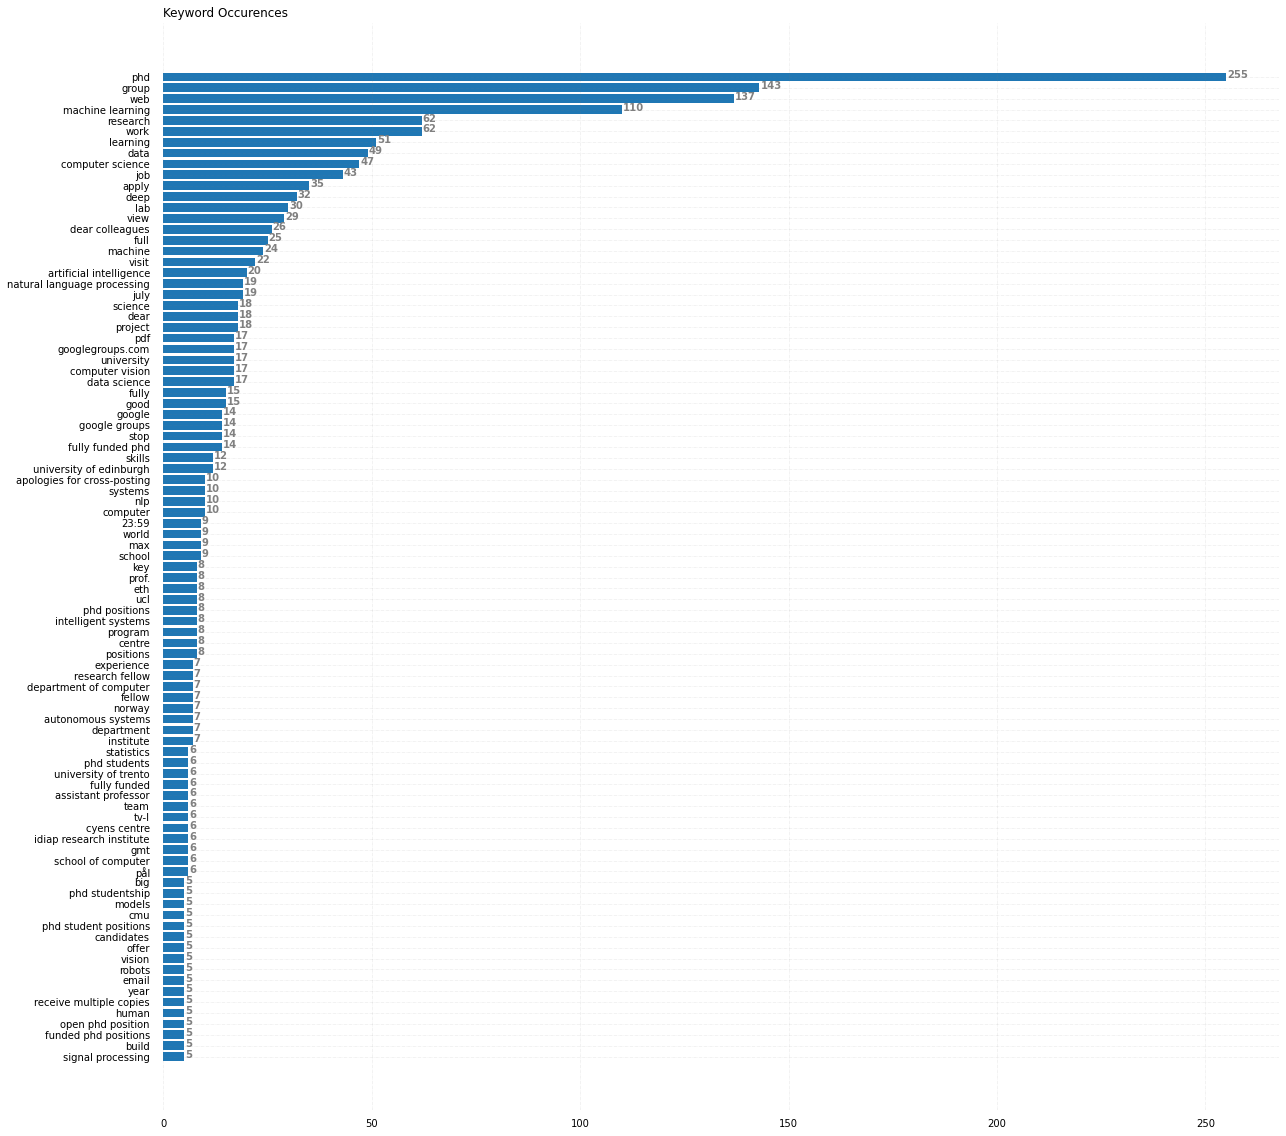

In [90]:
plotCounts(dfcount['keyword'], dfcount['value'])

In [81]:
print(len(re.findall(r"(?=.*^((?!\[job\]).)*$)(?=.*^((?!\[jobs\]).)*$)(?=.*^((?!fellowship).)*$)(?=.*phd)","something something phd ")))

1


In [199]:
client = pymongo.MongoClient('mongodb://localhost:27017/')

db = client['NLP']
collection = db['DataAll']

docs = collection.find({},{"_id":0})
concatTopics = ""
for i in docs:
    concatTopics = concatTopics + re.sub(" +", " ", re.sub("\n", " ", str(i['Topic']))) + "\n"


In [202]:
len(concatTopics)

82331

In [120]:
openai.api_key = "My-key"  #Mine
points = [0,18500, 37000, 55500, 74000, 92500]
responses = []
for i in range(len(points)-1):
    start = points[i]
    end = points[i + 1]
    response = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo-0301",
                    messages=[
                        {"role": "user", "content": "Take the following list of job descriptions from the area of ML and return the general topics that are at the top of the hierarchy:" },
                        {"role": "user", "content": concatTopics[start:end]}
                    ],
                    temperature=0,
                    max_tokens=100
                )
    responses.append(response["choices"][0]["message"]["content"])

In [123]:
responses

['Machine Learning, Data Science, Artificial Intelligence, Deep Learning, Statistics, Neuroscience, Robotics, Natural Language Processing, Computer Science, Image Analysis, Computational Biology, Optimization, Autonomous Driving, Remote Sensing, Visualization, Biostatistics, Network Science, Medical Image Analysis, Fairness and Transparency, Causality, Computing and Society, Human Understanding of Machines and Algorithms.',
 'am in Machine Learning and Artificial Intelligence \n\nGeneral topics: \n- Machine Learning \n- Artificial Intelligence \n- Robotics \n- Computer Vision \n- Deep Learning \n- Reinforcement Learning \n- Data Science \n- Natural Language Processing \n- Causal Inference \n- Biomolecular Simulation \n- Social Media Modelling \n- MultiAgent Systems \n- Haptic-based Teleoperation \n- Autonomous Systems \n- Cybersecurity \n- Image Processing \n- High-Performance Computing \n- Bioengineering \n- Ethics in AI',
 'General topics: \n- PhD positions in computer science, robot

In [179]:
splitResponses = []
for i in responses:
    i = re.sub("The general topics at the top of the hierarchy for these job descriptions are: |General topics: ", "", i)
    i = re.sub("\n\n", "\n", i)
    splitResponses.append(re.split(', |\n- ',i))

In [180]:
splitResponses = [topic for listTopics in splitResponses for topic in listTopics]
splitResponses = [re.sub(" $|^and |\n|\\.", "", topic).lower() if topic != 'and AI ' else '' for topic in splitResponses]
splitResponses = list( dict.fromkeys(splitResponses) )
splitResponses = list(filter(None, splitResponses))

In [181]:
splitResponses

['machine learning',
 'data science',
 'artificial intelligence',
 'deep learning',
 'statistics',
 'neuroscience',
 'robotics',
 'natural language processing',
 'computer science',
 'image analysis',
 'computational biology',
 'optimization',
 'autonomous driving',
 'remote sensing',
 'visualization',
 'biostatistics',
 'network science',
 'medical image analysis',
 'fairness and transparency',
 'causality',
 'computing and society',
 'human understanding of machines and algorithms',
 'am in machine learning and artificial intelligence',
 'computer vision',
 'reinforcement learning',
 'causal inference',
 'biomolecular simulation',
 'social media modelling',
 'multiagent systems',
 'haptic-based teleoperation',
 'autonomous systems',
 'cybersecurity',
 'image processing',
 'high-performance computing',
 'bioengineering',
 'ethics in ai',
 'phd positions in computer science',
 'postdoctoral research positions in machine learning',
 'faculty positions in ai',
 'research positions in hea

In [182]:
with open("general topics list.txt", "w") as output:
    output.write(str(splitResponses))

In [187]:
topics = ''
for i in range(len(splitResponses)):
    if i != len(splitResponses)-1:
        topics = topics + splitResponses[i] + ', '
    else:
        topics = topics + splitResponses[i]
     

In [188]:
topics

'machine learning, data science, artificial intelligence, deep learning, statistics, neuroscience, robotics, natural language processing, computer science, image analysis, computational biology, optimization, autonomous driving, remote sensing, visualization, biostatistics, network science, medical image analysis, fairness and transparency, causality, computing and society, human understanding of machines and algorithms, am in machine learning and artificial intelligence, computer vision, reinforcement learning, causal inference, biomolecular simulation, social media modelling, multiagent systems, haptic-based teleoperation, autonomous systems, cybersecurity, image processing, high-performance computing, bioengineering, ethics in ai, phd positions in computer science, postdoctoral research positions in machine learning, faculty positions in ai, research positions in healthcare, agriculture, topics in deep learning, bayesian methods, applications of ai and machine learning in various fi

In [189]:
with open("general topics string.txt", "w") as output:
    output.write(topics)

In [190]:
len(topics)

1679

In [286]:
points = [0, 4575, 9150, 13725, 18300, 22875, 27450, 32025, 36600, 41175, 45750, 50325, 54900, 59475, 64050, 68625, 73200, 77775, 82450]
newresponses = []
for i in range(len(points)-1):
    print(i)
    start = points[i]
    end = points[i + 1]
    response = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo-0301",
                    messages=[
                        {"role": "user", "content": "Take the following list of general topics and job descriptions from the area of ML and classify each job into only one of the general topcis provided in the format Job description: general topic" },
                        {"role": "user", "content": "Topics:" + topics},
                        {"role": "user", "content": "Jobs:" + concatTopics[start:end]}
                    ],
                    temperature=0,
                    max_tokens=2900
    )
    newresponses.append(response["choices"][0]["message"]["content"])
print(newresponses)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
['Postdoctoral Fellowship in Psychology-Inspired Computing for Robot Assistants: Robotics\nPostdoctoral Fellowship in Data Science: Data Science\nPhD fellowship in data science, machine learning and artificial intelligence: Data Science, Machine Learning, Artificial Intelligence\nPrize Fellowship in Machine Learning Machine Learning: Machine Learning\nResearch postdoc in 3D pose estimation and uncertainty quantification: Computer Vision\nGraph Machine Learning: Machine Learning, Network Science\nPostdoctoral position in federated learning in probabilistic classifiers: Machine Learning\nPostdoctoral fellowships in theoretical neuroscience: Neuroscience\nPhD fellowship in ML for antibiotic resistance research: Machine Learning, Computational Biology\nPhD fellowship in Continual Skill Learning: Machine Learning\nArtificial Intelligence technologies for the analysis of images captured by drones employed to fly over cultivated areas: Image Analysi

In [287]:
moreDetailedResponses = newresponses
newresponses = ['search Fellowship in Machine Learning for Robot Assistants: Robotics \nPostdoctoral Fellowship in Data Science: Data Science \nPhD fellowship in data science, machine learning and artificial intelligence: Data Science \nPrize Fellowship in Machine Learning: Machine Learning \nResearch postdoc in 3D pose estimation and uncertainty quantification: Computer Vision \nGraph Machine Learning: Machine Learning \nPostdoctoral position in federated learning in probabilistic classifiers: Machine Learning \nPostdoctoral fellowships in theoretical neuroscience: Neuroscience \nPhD fellowship in ML for antibiotic resistance research: Computational Biology \nPhD fellowship in Continual Skill Learning: Machine Learning \nArtificial Intelligence technologies for the analysis of images captured by drones employed to fly over cultivated areas: Image Analysis \nIndustrial postdoc fellow in AI-based testing via large scale foundation models: Artificial Intelligence \nPh.D. Positions in Computer Science and Artificial Intelligence: Computer Science \nIIITD-IIITD Research Fellowship Research Fellowship: Artificial Intelligence \nPostdoctoral Fellowship in Machine Learning for Next Generation Biomedicine: Machine Learning \nLSE Fellowship in Statistics: Statistics \nPostdoctoral stay in Mathematics in Artificial Intelligence: Mathematics \nTutoring for undergraduate or master students: Education \nPhD or postdoc fellowship in data science: Data Science \nPhD/postdoc in theoretical machine learning or applications of machine learning in the energy sector: Machine Learning \nNUAcT Fellow Data and Digital: Data Science \nPostdoctoral Fellowship in Machine Learning for Brain Connectivity in Clinical Neuroscience: Neuroscience \nContinual Reinforcement Learning PhD fellowship: Machine Learning \nBloomberg Data Science Ph.D. Fellowship Program: Data Science \nFatima Fellowship 2023: Fellowship \nPostdoctoral fellowships in Social Foundations of Computation: Computer Science \nPostdoctoral Fellowship Complex Systems: Systems \nWallenberg NTU Presidential Postdoctoral Fellowship: Fellowship \nMarie Sklodowska-Curie Postdoctoral Fellowships: Fellowship \nPhD in Causal Inference and Machine Learning PhD in Causal Inference and Machine Learning: Causality \nSenior Research Associate in Statistical Machine Learning: Machine Learning \nPostdoctoral Fellowships: Fellowship \nCRCS Summer Fellowships for PhD students: Fellowship \nHerman Goldstine Memorial Postdoctoral Fellowship: Fellowship \nPostdoctoral research fellowship: Research \nIIITD-JPMC Postdoctoral Fellow Machine learning or Deep Learning for acoustic and/or language modeling: Machine Learning \nIAS Fellow: Fellowship \nResearch fellowship AI-based intelligent tutoring systems: Artificial Intelligence \nCOVID19 prognosis postdoctoral fellowship: Fellowship \nResearch Fellowship: Research \nDoctoral student fellowships: Fellowship \nResearch Fellowship program: Research \nResearch Fellowship in Systems Modelling and Quantitative Biomedicine: Biostatistics \nPostdoctoral Fellowship in Ethical AI: Ethics in AI \nPh.D. Fellowship Program in Data Science: Data Science \nFatima Fellowship 2022: Fellowship \nMachine Learning for Absolute Navigation Systems: Machine Learning \nPostdoctoral researcher in machine learning and medical image analysis: Medical Image Analysis \nResearch Fellow Explainable AI: Explainable AI \nHigh-dimensional stochastic optimization with application to prehospital care: Optimization \nPostdoctoral fellowship in Learning and Control of Avian-Inspired Drones Learning and Control of Avian-Inspired Drones: Robotics \nEnhancing scholarly research in the humanities using knowledge graph technology: Humanities \nUsing 3D modelling approaches for the analysis and communication: 3D Modelling \nAutomated Personalisation Techniques: Artificial Intelligence \nComputer Graphics / Immersive Virtual Reality: Computer Graphics \nConversational AI & Personal Assistant Technology: Artificial Intelligence \nEric and Wendy Schmidt AI in Science Postdoctoral Fellowships: Artificial Intelligence \nPhD scholarships in Natural Language Processing: Natural Language Processing \nTranslational Artificial Intelligence Research Fellowship in Ophthalmology (TAIRFO): Artificial Intelligence \nVisiting Professorships, Tenured Faculty Positions, Tenure-track Opportunities, Research Fellowships: Academic Positions \nPostdoctoral Fellowship Machine Learning & Health Analytics Machine Learning and its applications in Smart Health, Drug Discovery, and Bioinformatics: Machine Learning \nFlatiron Research Fellow Machine Learning / Statistics CCA: Machine Learning \nFlatiron Research Fellow Machine Learning and Computational Statistics CCM: Machine Learning \nPostdoctoral Fellowship in Data Science: Data Science \nDeep learning algorithms for remote sensing data analysis: Deep Learning \nBuilding models of ecosystems using physical modeling, machine learning, and efficient computation: Machine Learning \nPhD fellowship in Social Robotics for Children with Neurodevelopmental Disorders PhD fellowship in Social Robotics for Children with Neurodevelopmental Disorders: Social Robotics \nResearch Fellow in Artificial Intelligence: Artificial Intelligence \nPostdoctoral positions in various research areas: Research \nPostdoctoral Fellowship Assistance in the piloting of complex systems and decision making: Decision Making \nMcKenzie Postdoctoral Fellowships Program: Fellowship \nPostdoctoral fellow: Fellowship \nPhD fellowship on Learning Trustworthy Representations for Natural Language Processing PhD fellowship on Learning Trustworthy Representations for Natural Language Processing: Natural Language Processing \nPostDoctoral Research Fellowship: Research \nResearch Associate: Research \nFDA Research Fellow Position in artificial intelligence/machine learning (AI/ML) applied to digital pathology: Artificial Intelligence \nPostDoc position in autotuning mechanisms for neural networks: Neural Networks \nPostdoctoral Fellow in "ophthalmic data mining and machine learning" Postdoctoral Fellow in "ophthalmic data mining and machine learning": Medical Image Analysis \nMarie Skłodowska-Curie COFUND Action Postdoctoral Fellowship Data Technologies: Fellowship \nELITES Postdoctoral Fellowship NLP/ML/Semantic Web/Digital Health/Big Data: Natural Language Processing \nMachine Learning and Artificial Intelligence Machine Learning and Constraints (e.g. Privacy and Security): Machine Learning \nPhD Fellowship in \'Deep Learning for Synchrotron X-ray Tomography Data\': Deep Learning \nCSIRO Postdoctoral Fellowship for Machine Learning and Artificial Intelligence Decision Making: Artificial Intelligence \nNLP/ML/Semantic Web/Digital Health/Big Data Postdoctoral Fellowship at ELITES: Natural Language Processing \nMedical Image Processing Machine Learning, Computer-Aided Diagnosis: Medical Image Analysis \nPhD fellowship program in natural language processing and machine learning: Natural Language Processing \nFellowship Research Group (FRG) Leader: Leadership \nResearch Associates: Research \nPhD and PostDoc Fellowships: Fellowship \nPhD and Postdoctoral fellowships in Artificial Intelligence and Personalized Medicine: Artificial Intelligence \nLectureships in Statistics or Applied Probability Lectureships in Statistics or Applied Probability: Statistics \nResearch Fellowships in Statistics or Applied Probability Research Fellowships in Statistics or Applied Probability: Statistics \nEuropean machine learning PhD program: Machine Learning \nQuadrupedal Robot Learning: Robotics \nComputer Vision PostDoc Research Fellow: Computer Vision \nPostdoctoral fellowship Applying machine learning methods in environmental modeling with emphasis on weather and climate: Environmental Modeling \nPostdoctoral Research Fellow in Machine Learning for Mental Health Care Technology: Mental Health \nPhD and Postdoc/Researcher Fellowship in Reducing Vulnerability Regarding (Healthcare) Robotics: Robotics \nPostdoctoral fellowship in 2D/2.5D/3D/4D radiology image processing: Medical Image Analysis \nIAIFI Fellowship Program: Fellowship \nTheoretical Machine Learning: Machine Learning \nPostdoctoral training fellowships in theoretical neuroscience, machine learning and related areas: Neuroscience \nDevelopment of next-generation vortex coronagraphs: Optics \nApplication of deep learning techniques to exoplanet imaging: Deep Learning \nDevelopment of focal-plane wavefront sensing techniques using machine learning: Machine Learning \nPh.D. Fellowships on Interactive Media, Smart Systems, and Emerging Technologies: Emerging Technologies \nPostdoctoral fellowship in datadriven (including SGLD-type) algorithms & ML applications: Machine Learning \nResearch Fellowship Artificial intelligence techniques for monitoring adverse reactions of anticovid vaccines: Artificial Intelligence \nPhD Scholarship Explainable computational methods for the analysis of bioinformatics data produced by high-throughput CRISPR screening: Explainable AI \nPostDoctoral Fellowship on Automatic Machine Learning (AutoML): Machine Learning \nPostdoctoral fellow in machine learning and healthcare: Healthcare \nPostDoc Research Fellowship on Deep Learning and AI for Perception, Identification and Control of Biomimetic Oculomotor Systems: Deep Learning \nResearch Fellow in machine learning: Machine Learning \nPostdoc position in legal implications of engineering and sciences: Legal Implications \nPostdoctoral Researcher in Geometric Deep Learning: Deep Learning \nPostdoctoral Research Fellowship in Machine Learning for Mental Health Care Technology Machine Learning for Mental Health Care Technology: Mental Health \nPhD and PostDoc Fellowships: Fellowship \nPhD and Postdoctoral fellowships: Fellowship \nPhD and Postdoctoral fellowships in Artificial Intelligence and Personalized Medicine: Artificial Intelligence \nLectureships in Statistics or Applied Probability Lectureships in Statistics or Applied Probability: Statistics \nResearch Fellowships in Statistics or Applied Probability Research Fellowships in Statistics or Applied Probability: Statistics \nEuropean machine learning PhD program: Machine Learning \nQuadrupedal Robot Learning: Robotics \nComputer Vision PostDoc Research Fellow: Computer Vision \nPostdoctoral fellowship Applying machine learning methods in environmental modeling with emphasis on weather and climate: Environmental Modeling \nPostdoctoral Research Fellow in Machine Learning for Mental Health Care Technology: Mental Health \nPhD and Postdoc/Researcher Fellowship in Reducing Vulnerability Regarding (Healthcare) Robotics: Robotics \nPostdoctoral fellowship in 2D/2.5D/3D/4D radiology image processing: Medical Image Analysis \nIAIFI Fellowship Program: Fellowship \nTheoretical Machine Learning: Machine Learning \nPostdoctoral training fellowships in theoretical neuroscience, machine learning and related areas: Neuroscience \nDevelopment of next-generation vortex coronagraphs: Optics \nApplication of deep learning techniques to exoplanet imaging: Deep Learning \nDevelopment of focal', "Searcher in Geometric Deep Learning: Deep Learning\nNewton International Fellowship: n/a\nNatural Language Understanding and Dialog Modeling / Systems: Natural Language Processing\nPostdoc position in legal implications of engineering and sciences: Computing and Society\nPhD fellowship in Theoretical Machine Learning with a focus on Online Learning: Machine Learning\nOpen facultywide call for PhD positions: n/a\nPhD fellowship in Rhythmic Robotics: Robotics\nPhD fellowship in Crossmodal Rhythms: Neuroscience\nPostdoc fellowship in Rhythmic Robotics: Robotics\nPostdoc fellowship in Eye Tracking and Motion Capture of rhythmrelated behavior: Neuroscience\nPostdoc fellowship in fMRI: Neuroscience\nDoctoral Research Fellowship in Rhythmic Robotics: Robotics\nDoctoral Research Fellowship in Crossmodal Rhythms: Neuroscience\nPostdoctoral Research Fellowship in Rhythmic Robotics: Robotics\nPostdoctoral Research Fellowship in Eye Tracking and Motion Capture of rhythmrelated behavior: Neuroscience\nPostdoctoral Research Fellowship in fMRI: Neuroscience\nMachine Learning for Image Analysis in Lung Disease: Image Analysis\nPhD Positions EarlyStage Researcher (ESR) Fellowships in Advanced Visual and Geometric Computing for 3D Capture, Display, and Fabrication: Computer Science\nPostdoctoral researcher positions in Applied Mathematics: Statistics\nHarrison Assistant Professorship Statistics: Statistics\nCRiSM Research Fellowship Statistics: Statistics\nSpatiotemporal ML for Cardiovascular data: Machine Learning\nMultimodal ML for Neuropsychiatric data: Machine Learning\nMachine Learning/Data Mining Postdoctoral Fellowship: Machine Learning\nShastri Research Student Fellowship: n/a\nDesign and development of machine learning algorithms for object detection in a scene by a robotic system: Robotics\nBloomberg Data Science Research Grant Program Research in data science or creation of open source software used for data science: Data Science\nBloomberg Data Science Ph.D. Fellowship Program Data science research for Ph.D. students: Data Science\nPhD Fellowship in Natural Language Processing: Natural Language Processing\nMultiple vacancies in the School of Computer Science: n/a\nPhD in theoretical machine learning: Machine Learning\nComputational Neuroscience Fellowship: Neuroscience\nPostdoctoral Research Fellow in Machine Learning for Mental Health Care Technology Machine Learning for Mental Health Care Technology: Machine Learning\nPostdoctoral fellow in deep learning and computational biology: Deep Learning\nPostdoctoral Research Fellow: n/a\nResearch Intern/Fellow Position in Machine Learning for Health at MIT Machine Learning for Health: Machine Learning\nAssistant Professor in Computer Science and Systems: Computer Science\nAI Researcher: Artificial Intelligence\nSecurity and Privacy of Conversational AI Systems: Cybersecurity\nPhD position in Security and Privacy of Conversational AI Systems: Cybersecurity\nAssociate Research Fellow: n/a\nNumerical optimization for frugal artificial intelligence: Optimization\nPostdoctoral position in federated learning in probabilistic classifiers: Machine Learning\nSr Data Scientist in Computational Behavior Analytics in Digital Biomarkers Data Science: Data Science\nLecturer/Senior Lecturer/Associate Professor in Statistical Science: Statistics\nResearch Fellow in Deep Learning and Computer Vision: Deep Learning\nPostdoctoral researcher in generative representation learning algorithms and causal representation learning: Machine Learning\nPostdoctoral Research Associate in Computer Science and Biomedical Engineering: Computer Science\nProject Coordinator: n/a\nResearch Associate in machine learning for healthcare: Machine Learning\nProfessorship for Machine Learning: Machine Learning\nMachine Learning for Cancer Research: Machine Learning\nDeep Learning for Capsule Video Endoscopy: Deep Learning\nExperienced Developer for Medical Device Project: n/a\nDeep learning for joint natural language and knowledge processing: Natural Language Processing\nBraincomputer interfaces: Neuroscience\nLSE Fellowship in Statistics: Statistics\nSpeechbased affective computing and mHealth applications: Machine Learning\nResearch Technician in Optimization Hyperheuristics: Optimization\nNUAcT Fellow Data and Digital: Data Science\nPostdoctoral Research Fellow Postdoctoral research fellowship: n/a\nSenior Researcher in Machine Learning, Evolutionary Computation, FPGA design, or Cryptography: Machine Learning\nPostdoctoral position in Machine Learning for energy forecasting: Machine Learning\nRemote Sensing and Agriculture Postdoctoral or Master's Level Researcher: Remote Sensing\nPhD Fellow in Machine Learning for Digital Medicine: Machine Learning\nPostdoctoral position on the use of deep learning for video quality assessment: Deep Learning\nArtificial Intelligence for Earth Observation/Remote Sensing data: Artificial Intelligence\nResearch Associate (Postdoc) position in autonomous driving, explainable AI, natural language processing: Autonomous Driving\nPostdoc position in program synthesis and machine learning: Machine Learning\nOpen rank tenuretrack faculty position in computational biology and bioinformatics: Computational Biology\nTenuretrack faculty position in computational biomedicine: Computational Biology\nTenuretrack open rank faculty position in computational materials science: Computational Materials Science\nPostdoctoral Fellow in Deep Learningbased Image Quality Assessment: Deep Learning\nMachine learning engineer/scientist: Machine Learning\nLecturer in Computer Vision and Deep Learning for Digital Humanities Lecturer in Computer Vision and Deep Learning for Digital Humanities: Computer Vision\nPostdoctoral Fellow on Machine Learning for Energy Forecasting: Machine Learning\nPhD Positions in Computer Vision/Deep Learning for Autonomous Driving Computer Vision/Deep Learning for Autonomous Driving: Computer Vision\nPostdoctoral Researcher in process modelling and machine learning: Machine Learning\nScience and project management: n/a\nPostdoctoral Research Associate in deep learning for therapeutics engineering: Deep Learning\nHumanintheloop machine learning: Machine Learning\nAssistant Professor in Computer Science: Computer Science\nPh.D. student position: n/a\nPostdoctoral researcher position: n/a\nDoctoral student in Artificial Intelligence, Machine Learning, and Computer Vision: Artificial Intelligence\nTrustworthy Data Science: Data Science\nHuman Understanding of Machines and Algorithms: Computing and Society\nComputing and Society: Computing and Society\nCausality: Causality\nFairness and Transparency: Fairness and Transparency\nPostdoctoral position in Simulation of Wave Propagation group at BCAM with D. Pardo and V. Nava: Optimization\nData Engineer: n/a\nResearch Associate (RA) in Machine Learning: Machine Learning\nData Scientist Data Scientist: Data Science\nPostdoctoral Fellowship in COVID19 prognosis: n/a\nAIDeveloper: Artificial Intelligence\nMachine Learning: Machine Learning\nNatural Language Processing: Natural Language Processing\nGraphics, Simulation and Visual Computing: Computer Graphics\nBiostatistician/Bioinformatician interested in prediction models in cancer research: Biostatistics\nPostdoc position in Autonomous driving, Explainable AI, Natural Language Processing Postdoc position in Autonomous driving, Explainable AI, Natural Language Processing: Autonomous Driving\nPhD scholarship Expanding the Tree of Life through a digital view of museum collections (PHYLORAMA): Computational Biology\nPostdoctoral Research Associate in Computer Science: Computer Science\nPostdoctoral Research Fellow Optimisation approaches to planning and tactical control of aircraft: Optimization\nRobotics: Robotics\nPost Doc position Machine learning methods for analyzing food science data sets: Machine Learning\nResearch Fellow position to design, develop and evaluate visualbased solutions to control autonomous Unmanned Aerial Vehicles (UAVs): Robotics\nQuantitative network science: Network Science\nResearch Fellow in ObjectTracking and Target ReIdentification on UAV Images: Robotics\nResearch Fellow position in designing, developing and evaluating visualbased objecttracking and target reidentification solutions on images acquired by a network of Unmanned Aerial Vehicles (UAVs): Robotics\nAssociate Professorship of Medical Image Analysis: Medical Image Analysis\nTenuretrack position in data science: Data Science\nResearch Fellow in Artificial Vision and RealTime Systems: Computer Vision\nResearch Fellow in ObjectTracking and Person Reidentification for UAVs: Robotics\nRecurrent Neural Networks and Related Machines That Learn Algorithms: Machine Learning\nResearch Assistant/Associate for the “Endusers Fixing Fairness Issues (Effi) Exploring the role and impact of enduser humanintheloop tools in ensuring fair Artificial Intelligence (AI)” project: Fairness and Transparency\nMachine Learning and Biomolecular Simulation Postdoctoral Associate: Machine Learning\nPostdoctoral fellow in machine learning and/or biomolecular simulation: Machine Learning\nTechnology Expert / Senior Application Developer (Fast Prototyping Capability Within TMACC Activities): n/a\nPostdoc position in deep learning for computer vision: Deep Learning\nSenior Postdoctoral Research Officer in Social Media Modelling Job 1: Social Media Modelling\nPhD scholarship in Modelling beliefs dynamics of social media users with machine learning methodologies Job 2: Social Media Modelling\nSenior Postdoctoral Research Officer Modelling beliefs dynamics of social media users with machine learning methodologies: Social Media Modelling\nPhD Scholarship Modelling beliefs dynamics of social media users with machine learning methodologies: Social Media Modelling\nPostdoc Position in MultiAgent Systems MultiAgent Systems: Multiagent Systems\nPostdoc and PhD Positions in Modelling beliefs dynamics of social media users with machine learning methodologies Modelling beliefs dynamics of social media users with machine learning methodologies: Social Media Modelling\nData Scientist: Data Science\nInformationOriented Planning with rhoPOMDPs: Optimization\nData Scientist Data Scientist: Data Science\nPostdoc Position in MultiAgent Systems Model Criticism in MultiAgent Systems: Multiagent Systems\nMachine Learning Engineer: Machine Learning\nPostdoctoral Research Associate in Computer Science: Computer Science\nLearning methods for visionbased autonomous landing of civil aircraft: Autonomous Driving\nOpen Phd position in Machine Learning and Neuroscience: Machine Learning\nDe: n/a", 'Ep Learning for Computer Vision: deep learning, computer vision\n\nPostdoctoral Fellowship in Psychology-Inspired Computing for Robot Assistants: robotics, artificial intelligence\n\nW3 Professor in Machine Learning: machine learning, computer science\n\nPhD student position in reinforcement learning and planning for hardware accelerator design: reinforcement learning, computer science\n\nPostdoctoral researcher or doctoral student in reinforcement learning and/or geometric deep learning: reinforcement learning, deep learning\n\nResearch Data Scientist: data science, statistics\n\nHaptic-based teleoperation with proactive and expressive robotic manipulators: robotics, haptic technology\n\nLearning, user modelling and assistive shared control to support wheelchair users: robotics, assistive technology\n\nLong term autonomy and mobile inspection of extreme environments with a quadruped robot: robotics, autonomous systems\n\nExploring Bilateral Trustworthiness in Human-Robot Collaborative Work: human-robot interaction, ethics in AI\n\nLifelong learning with robotic vacuum cleaners in social spaces: robotics, machine learning\n\nPostdoc position Machine Learning for Hearing Aid Signal Processing Machine Learning for Hearing Aid Signal Processing: machine learning, signal processing\n\nFull Professor in Machine Learning: machine learning, computer science\n\nPhD researcher position in anomaly detection from short video clips of produced parts: anomaly detection, computer vision\n\nPostdoctoral Research Fellow in Computer Vision and AI: computer vision, artificial intelligence\n\nGraduate Teaching Assistant (GTA) PhD Studentship Computer Science and Informatics: computer science, informatics\n\nGraduate Teaching Assistant (GTA) PhD Studentship Computer Vision and Artificial Intelligence: computer vision, artificial intelligence\n\nPostdoctoral research fellow in computer vision and artificial intelligence: computer vision, artificial intelligence\n\nPhD studentship in computer vision and artificial intelligence: computer vision, artificial intelligence\n\nPh.D. student position Multirobot systems, human-robot teaming/interaction, robot learning, and computer vision: robotics, computer vision\n\nLecturer in Robotics and Mechatronic Systems Lecturer in Robotics and Mechatronic Systems: robotics, mechatronics\n\nTopological Methods for Learning to Steer Self-Organised Growth: machine learning, optimization\n\nModelling compositional language structures across languages: natural language processing, linguistics\n\nPostdoctoral position in reinforcement learning and planning for hardware accelerator design Reinforcement learning and planning for hardware accelerator design: reinforcement learning, computer science\n\nPostdoctoral researcher in Robotics and Robot Learning: robotics, machine learning\n\nApplied Research Intern, ML/NLP: machine learning, natural language processing\n\nAnomaly Detection PhD Researcher Position: anomaly detection, machine learning\n\nPostdoc position: n/a\n\nPhD position: n/a\n\nResearch Associate/Senior Research Associate in statistical methodology and applied data analysis: statistics, data science\n\nFairness in Machine Learning and AI Planning: fairness, artificial intelligence\n\nPhD fellowship in Continual Skill Learning: machine learning, continual learning\n\nAssistant Professor "Logic in Artificial Intelligence": artificial intelligence, logic\n\nArtificial Intelligence technologies for the analysis of images captured by drones employed to fly over cultivated areas: artificial intelligence, remote sensing\n\nPHD PROGRAM in TRANSLATIONAL NEUROSCIENCES AND NEUROTECHNOLOGIES: neuroscience, neurotechnology\n\nSoftware Engineer for Machine Learning team: software engineering, machine learning\n\nPh.D. Positions in Computer Science and Artificial Intelligence: computer science, artificial intelligence\n\nRobotics Ph.D. position Robotics Ph.D. position: robotics, computer science\n\nUniversity Professor for AI Safety and Security: artificial intelligence, cybersecurity\n\nDirector of the Institute for AI Safety and Security: artificial intelligence, cybersecurity\n\nChoose France CNRS AI Rising Talents programme: artificial intelligence, career development\n\nFully funded PhD scholarship in Robotics and AI Social perception in unstructured environments Robotics and AI Social perception in unstructured environments: robotics, artificial intelligence\n\nPostdoctoral Researcher in Causal Inference: causal inference, statistics\n\nComputational Vision PHD Positions: computer vision, machine learning\n\nAssistant Professor in Machine Learning and Autonomous Systems: machine learning, autonomous systems\n\nRobotics and Artificial Intelligence Robotics and Artificial Intelligence: robotics, artificial intelligence\n\nPhD candidate: n/a\n\nDoctoral Candidate Researchers (PhD students) in neural network technology, intelligent robotics and transparency/explainability in artificial intelligence: artificial intelligence, robotics\n\nDoctoral Candidate research positions at Universität Hamburg which will be filled in the context of transparency and interpretation of neural networks for interactive cognitive robots: artificial intelligence, robotics\n\nPostdoctoral positions in Robotics and Learning: robotics, machine learning\n\nDoctoral student positions in Robotics and Learning: robotics, machine learning\n\nTeaching in the area of databases, networking, data visualization and machine learning: computer science, data science\n\nData Science Professorship Data Science Professorship: data science, statistics\n\nFull Professor or Tenure-Track Assistant Professor in Data Science: data science, statistics\n\nPhD Candidate in Causal Representation Learning and Fusion from Multiple Modalities Causal Representation Learning and Fusion from Multiple Modalities: causal inference, machine learning\n\nMachine learning and AI applied to understand and contrast social media threats for teenagers: machine learning, artificial intelligence, social media\n\nELLIS PhD Program: machine learning, artificial intelligence\n\nRobotics Junior Engineer Position: robotics, engineering\n\nPhD scholarship in Machine Learning and Deep Learning: machine learning, deep learning\n\nResearch fellow (postdoc) in developing AI methods for health-related tasks: artificial intelligence, healthcare\n\nRobotics faculty positions: robotics, academia\n\nCybersecurity: cybersecurity\n\nArtificial Intelligence and Data Science techniques applied to cybersecurity and/or to social media analytics: artificial intelligence, data science, cybersecurity, social media\n\nMachine Learning academic position: machine learning, academia\n\nFederated Learning, Privacy, Security, Edge Intelligence and Computer Vision Research Scientist: machine learning, computer vision, privacy, security\n\nFederated Learning, Privacy, Security, Edge Intelligence and Computer Vision Intern: machine learning, computer vision, privacy, security\n\nResearch Assistant in Computational Neuroscience: neuroscience, computational neuroscience\n\nAssistant Professor in Collaborative AI Collaborative AI: artificial intelligence, collaboration\n\nSecondmind\'s 2022 internship programme: machine learning, internship\n\nW3 Associate/Full Professor Robot Learning: robotics, machine learning\n\nDeep Reinforcement Learning for Exploring Sustainable Agroecological Transition Pathways: reinforcement learning, sustainability\n\nGeolocalising Knowledge Graphs Fellow Intern: artificial intelligence, knowledge graphs\n\nMachine learning for causal inference: machine learning, causal inference\n\nComputational Neuroscience Research Assistant/Postdoc: neuroscience, computational neuroscience\n\nPostdoc position: n/a\n\nPhysics-informed machine learning for solar wind forecasting and solar wind propagation modeling: machine learning, physics\n\nPhD Studentship in Modelling Human-Robot Interaction in Social Spaces: human-robot interaction, modeling\n\nComputer Vision and Machine Learning Researcher: computer vision, machine learning\n\nHPC Network Engineer HPC Network Engineer: high-performance computing, networking\n\nContinual Reinforcement Learning PhD fellowship: reinforcement learning, continual learning\n\nResearcher in NeuroSymbolic AI and NLP: artificial intelligence, natural language processing\n\nPostdoc position in the TriFORCE project: robotics, artificial intelligence\n\nPh.D. student position in the TriFORCE project: robotics, artificial intelligence\n\nCentralized algorithms/backend development: software engineering, algorithms\n\nFederated learning and frontend development: machine learning, software engineering\n\nLSE Fellowship in Statistics: statistics, academia\n\nPhD position in disentangled representations, computer vision, and medical image analysis: computer vision, medical image analysis\n\nInterdisciplinary PhD studentship in human-robot interaction: human-robot interaction, interdisciplinary\n\nResearch Software Engineer: software engineering, research\n\nMaster trainee in the MERLE project: robotics, engineering\n\nMachine Learning and Bioacoustics: machine learning, bioacoustics\n\nPhD studentship in Causality in retail data science: causality, data science\n\nPostdoctoral position in data-driven atmospheric cloud research: data science, atmospheric science\n\nPostdoctoral researcher in robotics: robotics, research\n\nPostdoctoral Position in Robot Learning and Planning for Mobile Manipulation Robot Learning and Planning for Mobile Manipulation: robotics, machine learning\n\nComputer Science Postdoctoral Researcher: computer science, research\n\nPh.D. Positions in Computer Science and Artificial Intelligence with Full 5-year Fellowships: computer science, artificial intelligence\n\nPostdoctoral Research Associate in Applied Medical Statistics: statistics, medical research\n\nFaculty Positions in Computer Science, Mathematics, Data Science, and Artificial Intelligence: computer science, mathematics, data science, artificial intelligence\n\nProfessor/Associate Professor: academia\n\nMachine Learning Researcher/Professor: machine learning, academia\n\nRobotics Ph.D. position: robotics, computer science\n\nData Scientist, Machine Learning Specialist, Machine Learning Engineer, Data Engineer: data science, machine learning, software engineering\n\nSenior Data Engineering roles: data engineering, software engineering\n\nPhD position in disentangled representations, computer vision, and medical image analysis interpretability of applied machine learning overparameterization and generalizability in deep neural architectures web & information retrieval: computer vision, medical image analysis, machine learning, information retrieval\n\nPostdoctoral researcher on brain-inspired machine learning: machine learning, neuroscience\n\nAI/ML applied science leader: artificial intelligence, machine learning, leadership\n\nApplied scientists: artificial intelligence, machine learning, research\n\nPh.D. positions in robotics, computer vision, and machine learning: robotics, computer vision, machine learning\n\nVarious research projects in machine learning, computer vision, and robotics: machine learning, computer vision, robotics\n\nResearch Scientist Natural Language Processing, Machine Learning, Data Management and Integration, Data Mining, Knowledge Representation, Bot interfaces, Crowdsourcing, and Visualization: natural language processing, machine learning, data management, data mining, knowledge representation, crowdsourcing, visualization\n\nPostdoctoral Fellow within Robot and Sensor Integration: robotics, sensor integration\n\nPostdoctoral research fellow in cognitive robot systems: robotics, cognitive systems\n\nPhD students', 'Machine learning: \n- ML Engineer for Autonomous Driving \n- Postdoctoral position Deep generative methods for fragrance synthesis \n- PhD position Representation learning and interpretability for reinforcement learning \n- Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding \n- Research on cross-data analysis AI technology for super smart society \n- Postdoc positions in machine learning/deep learning, computer science, applied math, operations research, optimization, statistics, control theory, or information theory. \n- PhD position in robotics, machine learning, and biomimetic motor control \n- Postdoctoral researcher or PhD student in Automated Machine Learning (AutoML), Neural Architecture Search (NAS), and/or Algorithm Selection possibly applied to Recommender Systems \n- Research associates in machine learning and robotics \n- PhD course in Bioengineering and Robotics Cognitive Robotics, Interaction and Rehabilitation Technologies \n- Ph.D. position in machine learning \n- Machine Learning Engineer for Autonomous Driving Systems \n- Postdoctoral research fellow in complex networks, dynamical systems, and Bayesian inference \n- Machine learning engineer/researcher for ML applications for remote sensing + food security in Sub-Saharan Africa \n- Mechanism-aware machine/deep learning for biomedicine \n- PhD Position in Deep Learning for Robotics \n\nData science: \n- Data Scientist in Cybersecurity \n- PhD studentships (Graduate Teaching Assistant) \n- Lecturer or Associate Professor in Media Futures \n- Data Representation and Engineering \n- Postdoctoral Researcher and Research Fellow Positions Multiple areas of ICT including artificial intelligence and machine learning, data science, privacy and security, computational health, human-computer interaction \n- AI Software Developer \n\nArtificial intelligence: \n- Choose France CNRS AI Rising Talents programme \n- Tenure-track positions in Robotics, AI and ML \n- Lecturer in Algorithmic Optimisation/Data Science/Machine Learning \n- Lecturer in High-Performance / Quantum Computing \n- Lecturer in Natural Language Processing and Information Retrieval \n- Senior academic position in Artificial Intelligence \n- Postdoctoral researcher or PhD student in Automated Machine Learning (AutoML), Neural Architecture Search (NAS), and/or Algorithm Selection possibly applied to Recommender Systems \n- Lecturer or Associate Professor in Media Futures \n- Assistant Professors (2), Artificial Intelligence, tenure track, Department of Electrical and Computer Engineering Artificial Intelligence \n- Senior Researcher Artificial Intelligence \n- PhD Vacancy in AI for Process Control \n- Assistant/Associate/Full Professor in Artificial Intelligence, Machine Learning, and Natural Language Processing \n\nDeep learning: \n- Postdoctoral position Deep generative methods for fragrance synthesis \n- PhD position Representation learning and interpretability for reinforcement learning \n- Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding \n- Postdoc positions in machine learning/deep learning, computer science, applied math, operations research, optimization, statistics, control theory, or information theory. \n- PhD position in robotics, machine learning, and biomimetic motor control \n- PhD course in Bioengineering and Robotics Cognitive Robotics, Interaction and Rehabilitation Technologies \n- PhD Position in Deep Learning for Robotics \n- Computer Vision for scene understanding and social behaviour analysis \n\nStatistics: \n- PhD position in Third Wave of AI \n- Chair/Full Professor level position in statistical science \n- Lecturer/Senior Lecturer/Associate Professor level position in statistical science \n\nNeuroscience: \n- PhD position in robotics, machine learning, and biomimetic motor control \n- Postdoctoral Researcher in neurosymbolic Artificial Intelligence \n- PHD PROGRAM in TRANSLATIONAL NEUROSCIENCES AND NEUROTECHNOLOGIES \n\nRobotics: \n- ML Engineer for Autonomous Driving \n- Tenure-track positions in Robotics, AI and ML \n- Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding \n- Early-Stage Researcher (ESR) position in Personalized Social Cues for Robots as Information Providing Interfaces at Università Degli Studi di Napoli Federico II, Italy. \n- Postdoctoral researcher and PhD student positions in robotics and machine learning \n- Robotics Ph.D. student Robotics \n- PhD position in Machine Learning for Autonomous Robot Manipulation \n- Postdoc position on interpretable computer vision methods for species identification \n- PhD position on interpretable computer vision methods for species identification \n- Robotics postdoctoral researcher \n- Robotics and Shared Control PhD studentship \n\nNatural language processing: \n- PhD position Representation learning and interpretability for reinforcement learning \n- Lecturer in Natural Language Processing and Information Retrieval \n- Postdoctoral researcher or PhD student in Automated Machine Learning (AutoML), Neural Architecture Search (NAS), and/or Algorithm Selection possibly applied to Recommender Systems \n\nComputer science: \n- PhD position Representation learning and interpretability for reinforcement learning \n- Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding \n- PhD position in robotics, machine learning, and biomimetic motor control \n- Lecturer in Algorithmic Optimisation/Data Science/Machine Learning \n- Lecturer in High-Performance / Quantum Computing \n- Lecturer in Natural Language Processing and Information Retrieval \n- Postdoctoral Researcher in (Structured) Machine Learning \n- Research on cyberphysical systems for behavior support using IoT data \n- PhD Positions in Computer Science \n- Lecturer in Algorithmic Optimisation/Data Science/Machine Learning \n- Lecturer in HighPerformance / Quantum Computing \n- Lecturer in Natural Language Processing and Information Retrieval \n- Postdoc opening in the area of human-guided robotic learning \n- PhD student positions in computer science \n- Ph.D./MS student to develop a complete course in ML and Deep Learning in Text form \n- Summer Internship at FiveAI \n- Job Title Nontenure track Fulltime Research Professor Position for Software/Computer Science Research \n- Gaussian process models and Bayesian optimization \n\nImage analysis: \n- Postdoctoral position Deep generative methods for fragrance synthesis \n- Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding \n- Research Associate in deep learning based compression of large-scale satellite images \n- PhD position on "Computer vision for animal welfare" \n- Postdoctoral Research Associate (PDRA) position in GAN/deep learning for the early detection of pancreatic cancer GAN/deep learning for the early detection of pancreatic cancer \n- Postdoctoral Research Associate (PDRA) position in GAN/deep learning for the early detection of pancreatic cancer \n- Postdoc position on interpretable computer vision methods for species identification \n- PhD position on interpretable computer vision methods for species identification \n- Computer Vision for scene understanding and social behaviour analysis Computer Vision for scene understanding and social behaviour analysis \n- Computer Vision for scene understanding and social behaviour analysis Computer Vision for scene understanding and social behaviour analysis \n- Research Associate in deep learning based compression of large-scale satellite images \n\nComputational biology: \n- PhD position in robotics, machine learning, and biomimetic motor control \n- Postdoc position in probabilistic machine learning for biological systems modelling \n\nOptimization: \n- Postdoctoral position Deep generative methods for fragrance synthesis \n- PhD position Representation learning and interpretability for reinforcement learning \n- Postdoc positions in machine learning/deep learning, computer science, applied math, operations research, optimization, statistics, control theory, or information theory. \n- PhD position in robotics, machine learning, and biomimetic motor control \n- Multi-objective optimisation under uncertainty for NPIs \n\nAutonomous driving: \n- ML Engineer for Autonomous Driving \n- PhD Position in Deep Learning for Robotics \n- Machine Learning Engineer for Autonomous Driving Systems \n\nRemote sensing: \n- Machine learning engineer/researcher for ML applications for remote sensing + food security in Sub-Saharan Africa \n- Research Associate in deep learning based compression of large-scale satellite images \n\nFairness and transparency: \n- Choose France CNRS AI Rising Talents programme \n- Lecturer or Associate Professor in Media Futures \n- Fully funded Ph.D. positions in socially responsible AI, causal machine learning, and social media mining \n\nCausality: \n- PhD position in Third Wave of AI \n- Postdoctoral Researcher in Causal Inference Causal Inference \n- Analyzing aspects of machine learning methodology related to ethical considerations \n\nComputing and society: \n- Choose France CNRS AI Rising Talents programme \n\nHuman understanding of machines and algorithms: \n- Choose France CNRS AI Rising Talents programme \n\nBiostatistics: \n- PhD position in Third Wave of AI \n\nNetwork science: \n- Research on cyberphysical systems for behavior support using IoT data \n- Research fellow position on methodology for medical records analysis Methodology for medical records analysis \n- Postdoctoral research fellow in complex networks, dynamical systems, and Bayesian inference \n\nMedical image analysis: \n- PhD position in robotics, machine learning, and biomimetic motor control \n- Research staff positions in machine learning and its applications in meteorology, earth sciences, and video prediction \n\nVisualization: \n- Data Visualization and Exploration (UTSG) Assistant Professor Data Visualization and Exploration (UTSG) Assistant Professor \n\nCybersecurity: \n- Data Scientist in Cybersecurity \n- Human Machine Interaction and CyberPhysical Security \n\nImage processing: \n- Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding \n- Research Associate in deep learning based compression of large-scale satellite images \n\nHigh-performance computing: \n- Lecturer in High-Performance / Quantum Computing \n- Senior HPC Systems Engineer Senior HPC Systems Engineer \n\nBioengineering: \n- PhD course in Bioengineering and Robotics Cognitive Robotics, Interaction and Rehabilitation Technologies \n- PhD and Postdoc positions in Deep NeuroCognition Lab \n\nEthics in AI:', 'Machine learning: \n- Postdoc position in human-robot interaction and machine learning \n- Postdoc position in computer vision and machine learning \n- Postdoc position in computer vision and machine learning \n- Machine Learning for Robotics \n- Postdoc position on deep learning for online 2D/2.5D/ 3D scene understanding from images \n- PhD in the field of explainable AI \n- Postdoctoral research associate position on Trustworthy AI \n- Postdoctoral research fellow in cognitive systems \n- Federated Learning, Privacy, Security, Edge Intelligence and Computer Vision Research Scientist \n- Federated Learning, Privacy, Security, Edge Intelligence and Computer Vision Research Intern \n- Fully funded PhD positions in robotics and machine learning \n- Metareinforcement learning \n- Interpretable and statistical continual learning \n- Doctoral student fellowships \n- Postdoc position in Neural Language models as Knowledge Bases \n- Multimodal ML for Neuropsychiatric data \n- Spatiotemporal ML for Cardiovascular data \n- Postdoc position on deep learning for 3D scene understanding from images \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoctoral Positions in Machine learning and/or Computer Vision \n- MRG Team Leader open for a wider range of topics \n- MRG Team Leader open specifically for Data Science and Network Science \n- Graph-based world models for sample efficient and human friendly reinforcement learning \n- Planning to learning world models to plan and learn \n- Transferable hierarchical reinforcement learning \n- Context-based curriculum learning for safe exploration \n- Senior Data Scientist / Machine Learning Engineer \n- Senior Data Scientist / Machine Learning Engineer \n- PhD candidate in Deep Learning Based Intelligence and Computationally Efficient Augmented Reality Systems \n- Postdoc position \n- Postdoc position in Computer Vision and Machine Learning \n- Machine Learning Researcher \n- Postdoctoral research fellow in computer vision and artificial intelligence \n- PhD studentship in computer vision and artificial intelligence \n- 4-year PhD. position in transfer learning for reinforcement learning \n- 4-year PhD. position in continual learning \n- Postdoctoral Research Fellow in deep learning (Graph Neural Networks) for the early detection of lung cancer \n- Postdoctoral Research Associate \n- AI engineer \n- Postdoc Machine learning, natural language processing, representation learning and explainable artificial intelligence \n- Machine Learning Researcher \n- Postdoctoral research fellow in computer vision and artificial intelligence \n- PhD studentship in computer vision and artificial intelligence \n- PhD fellowship in Reducing Vulnerability Regarding (Healthcare) Robotics \n- Postdoc/Researcher fellowship in Reducing Vulnerability Regarding (Healthcare) Robotics \n- Postdoctoral Research Fellow in deep learning (Graph Neural Networks) for the early detection of lung cancer \n- Postdoctoral Research Assistant in Dynamic Legged Locomotion \n- Postdoc Functional Memory Network in collaborative AI for cognitive assessment of human partners \n- Postdoc position in Robot Learning & Interaction \n- PhD Student position in Robot Learning & Interaction \n- Postdoc position in Robot Learning & Interaction \n- PhD Student position in Robot Learning & Interaction \n- AI/ML research engineer/scientist \n- AI/ML research engineer/scientist \n- PhD Positions \n- PhD position on tensor-based unsupervised learning methods for neuroimaging data fusion \n- PhD positions in the intersection of robotics and machine (deep) learning \n- Open Phd position in Machine Learning and Physics \n- Research Fellows for Robot Manipulation, Teleoperation and Machine Learning \n- Postdoctoral Fellow within Autonomous Navigation for Robots in Agriculture \n- Postdoctoral Research Fellow in Robotics \n\nData science: \n- Postdoctoral Researcher \n- Senior Data Scientist / Machine Learning Engineer \n- Senior Data Scientist / Machine Learning Engineer \n- Research on fundamental technologies for smart data analysis \n- Research on fundamental techniques for real-world analysis with smart data \n- PhD position in machine learning for detecting and managing future emerging pandemics \n- Postdoc Development of a multi-agent platform and analysis of the impact of COVID-19 Non-pharmaceutical Policy Interventions (NPIs) on behavior changes \n- PhD Understanding the impact of COVID-19 and improving our ability to recover from pandemics \n- Postdoctoral fellows in Clinical Machine Learning \n- Postdoctoral fellows in Clinical Data Science \n- PhD position \n- Lic. Ph.D. position in Computer Science and Engineering \n\nArtificial intelligence: \n- Postdoc position in human-robot interaction and machine learning \n- Robotics faculty position \n- Robotics faculty position \n- Postdoctoral Researcher \n- Postdoc position in computer vision and machine learning \n- Postdoc position in computer vision and machine learning \n- Postdoc position on deep learning for online 2D/2.5D/ 3D scene understanding from images \n- PhD in the field of explainable AI \n- Postdoctoral research associate position on Trustworthy AI \n- Postdoctoral research fellow in cognitive systems \n- Federated Learning, Privacy, Security, Edge Intelligence and Computer Vision Research Scientist \n- Federated Learning, Privacy, Security, Edge Intelligence and Computer Vision Research Intern \n- Fully funded PhD positions in robotics and machine learning \n- Postdoc position in Neural Language models as Knowledge Bases \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoctoral Positions in Machine learning and/or Computer Vision \n- MRG Team Leader open for a wider range of topics \n- MRG Team Leader open specifically for Data Science and Network Science \n- Postdoc Machine learning, natural language processing, representation learning and explainable artificial intelligence \n- Postdoctoral research fellow in computer vision and artificial intelligence \n- PhD studentship in computer vision and artificial intelligence \n- Postdoctoral Research Fellow in deep learning (Graph Neural Networks) for the early detection of lung cancer \n- Postdoctoral Research Associate \n- Postdoc position in Robot Learning & Interaction \n- PhD Student position in Robot Learning & Interaction \n- Postdoc position in Robot Learning & Interaction \n- PhD Student position in Robot Learning & Interaction \n- AI/ML research engineer/scientist \n- AI/ML research engineer/scientist \n- PhD Positions \n- PhD position on tensor-based unsupervised learning methods for neuroimaging data fusion \n- PhD positions in the intersection of robotics and machine (deep) learning \n- Open Phd position in Machine Learning and Physics \n- Postdoctoral Research Fellow in Robotics \n\nDeep learning: \n- Postdoc position in computer vision and machine learning \n- Postdoc position in computer vision and machine learning \n- Postdoc position on deep learning for online 2D/2.5D/ 3D scene understanding from images \n- Postdoc position on deep learning for 3D scene understanding from images \n- PhD in the field of explainable AI \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Fully funded PhD positions in robotics and machine learning \n- Postdoctoral Research Fellow in deep learning (Graph Neural Networks) for the early detection of lung cancer \n\nStatistics: \n- PhD in the field of explainable AI \n- Postdoctoral research associate position on Trustworthy AI \n- Postdoctoral research fellow in cognitive systems \n- Doctoral student fellowships \n- Postdoc position in Neural Language models as Knowledge Bases \n- Postdoctoral Research Fellow in deep learning (Graph Neural Networks) for the early detection of lung cancer \n\nNeuroscience: \n- Postdoctoral research fellow in cognitive systems \n- Multimodal ML for Neuropsychiatric data \n- Spatiotemporal ML for Cardiovascular data \n- PhD position on tensor-based unsupervised learning methods for neuroimaging data fusion \n\nRobotics: \n- Postdoc position in human-robot interaction and machine learning \n- Robotics faculty position \n- Robotics faculty position \n- Machine Learning for Robotics \n- Postdoc position on deep learning for online 2D/2.5D/ 3D scene understanding from images \n- Fully funded PhD positions in robotics and machine learning \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoc Functional Memory Network in collaborative AI for context awareness and action planning in robotics \n- Postdoctoral Positions in Machine learning and/or Computer Vision \n- Postdoc position in Robot Learning & Interaction \n- PhD Student position in Robot Learning & Interaction \n- Postdoc position in Robot Learning & Interaction \n- PhD Student position in Robot Learning & Interaction \n- Researcher in Reducing Vulnerability Regarding (Healthcare) Robotics \n- Postdoctoral fellow within autonomous navigation \n- Postdoctoral fellow within applications for robots in the agricultural domain \n- Research Fellows for Robot Manipulation, Teleoperation and Machine Learning \n- Postdoctoral Fellow within Autonomous Navigation for Robots in Agriculture \n- Postdoctoral Research Fellow in Robotics \n\nNatural language processing: \n- Postdoc position in Neural Language models as Knowledge Bases \n- Postdoc Machine learning, natural language processing, representation learning and explainable artificial intelligence \n\nComputer science: \n- Postdoc position in human-robot interaction and machine learning \n- PhD in the field of explain', 'Postdoctoral Research Fellow in Robotics: Robotics\nPostdoctoral fellow within Data Acquisition and Analysis for the Agricultural Domain: Agriculture\nNeurorobotics: Neuroscience\nPostdoctoral position (Deep) reinforcement learning and/or multiarmed bandits: Reinforcement Learning\nAssistant Professors in Datadriven Intelligence (DDI): Data Science\nPostdoctoral research fellow: n/a\nPostdoctoral Research Assistant in Dynamic Legged Locomotion legged locomotion, motion planning and optimizationbased approaches for dynamic robots in realworld environments: Robotics\nResearchminded programmers for human prediction problems: Machine Learning\nPhD position on reinforcement learning for autonomous driving: Autonomous Driving\nPostdoc position in "Statistical inference on graphs": Statistics\nResearch Associate EgoNoise Reduction for Interactive Robots: Robotics\nPostdoctoral researcher: n/a\nPostdoctoral Researcher in Machine Learning and Robotics: Machine Learning and Robotics\nPost Doc on "Social interaction analysis, with application to the estimation of emotional wellbeing in older citizens": Machine Learning and Artificial Intelligence\nResearch associates in machine learning and robotics: Machine Learning and Robotics\nPhD student forum on machine learning and knowledge discovery: Machine Learning\nPhD position in structured generative models of images and videos: Image Analysis\nPhD in Advanced Machine Learning: Advanced Machine Learning\nPhD programme in Advanced Machine Learning: Advanced Machine Learning\nPhD student in Machine Learning in the area of simulationbased inference: Machine Learning\nPhD position on application of AI and ML in healthcare: Healthcare\nBayesian computational methods in Epidemics, specifically using nontraditional sources of data: Statistics\nPhD students in Computational Precision Health: Healthcare\nPhD position in Bayesian machine learning and deep learning: Bayesian Methods\nIdentifying biases in the news using models of narrative framing: Machine Learning\nPhD position NeuroSymbolic Models: Artificial Intelligence\nPhD Research Intern: n/a\nPhD student Human visual recognition inspired multiagent reinforcement learning for drone search and rescue in complex environment: Reinforcement Learning\nResearch Scientist: n/a\nSemisupervised Learning Based Parametric Study of PV Array Output Characteristics for the Diagnosis and Quantification of Concurrent Faults: Machine Learning\nPhD Forum at the 21st International Symposium on Intelligent Data Analysis (IDA): Data Analysis\nBiases in Health Records: Healthcare\nExplainable AI of Social Signals: Explainable AI\nPhD OutOfDistribution Detection for Medical AI: Medical AI\nPhD position in security and privacyenhancing techniques for federated machine learning: Cybersecurity\nUtilising vocal biomarkers and artificial intelligence to model symptoms of central nervous system disorders: Artificial Intelligence and Healthcare\nPhD research fellow in artificial intelligence and machine learning tools for UAV communication: Artificial Intelligence and Machine Learning\nPhD position in NLP: Natural Language Processing\nPhD student in a project dealing with anonymization and synthesis of click paths and behavior on the web: Data Privacy\nDoctoral Fellowship Program in AI: Artificial Intelligence\nResearch collaborator position in machine learning: Machine Learning\nPhD student and Postdoctoral level positions in Machine Learning: Machine Learning\nLearning disentangled representations to achieve responsible and transparent AI: Responsible and Transparent AI\nPh.D. position: n/a\nPhD position in reinforcement learning for public health decision making: Reinforcement Learning and Healthcare\nPhD position in cellular biology and machine learning: Computational Biology and Machine Learning\nPh.D. opportunity in Vision and Image Processing: Image Processing\nPhD in machine learning or theoretical neuroscience: Machine Learning and Theoretical Neuroscience\nfunctional data and image data machine learning PhD scholarship: Machine Learning\nPhD / Teaching role: n/a\nFully funded PhD Studentships: n/a\n"Robust Learning of Sparse Representations in Neural Networks": Neural Networks\nDevelop humanAI interactive models for accountable drought predictions: Artificial Intelligence and Agriculture\nPh.D. in statistics and machine learning for forecasting: Statistics and Machine Learning\nPhD positions in deep learning for automated planning and scheduling: Deep Learning\nPostdoc position in deep learning for automated planning and scheduling: Deep Learning\nNatural Language Processing and Deep Learning: Natural Language Processing and Deep Learning\nPhD Studentships: n/a\nPostdoctoral position on the generation of XR representations of industrial objects and environments: XR Representations\nPhD student position on the characterization of craftmanship through multimodal sensing: Multimodal Sensing\nPhD position in audiovisual speech enhancement: Audiovisual Speech Enhancement\nPhD positions in Machine learning and Remote sensing: Machine Learning and Remote Sensing\nResearch Assistant: n/a\nPh.D. Research Fellowship in Machine Learning: Machine Learning\nPhD studentship position Natural Language Processing, Deep Learning, and Machine learning algorithms: Natural Language Processing, Deep Learning, and Machine Learning\nWiML Mentorship Program Mentorship program for Ph.D. applicants: Mentorship Program\nPh.D. scholarship in social and cognitive robotics: Social and Cognitive Robotics\nPhD Studentship in Clinical Informatics: Clinical Informatics\nPhD position: n/a\nPhD forum PhD forum in data mining, machine learning and related areas: Data Mining and Machine Learning\nPhD Studentship: n/a\nPhD Residency: n/a\nPhD Internship Opportunities: n/a\nAI ML PhD Intern: Artificial Intelligence and Machine Learning\nAI Research PhD Intern: Artificial Intelligence\nPhD Research Intern: n/a\nPhD position in computational and learning theoretic aspects of machine learning: Machine Learning\nPhD Open Day PhD in Statistics: Statistics\nAdditive constrained Gaussian processes in high dimension: Gaussian Processes\nKnowledgeaware fewshot learning: Fewshot Learning\nInformation retrieval models for structured and verbose queries: Information Retrieval\nPhD research fellow in artificial intelligence and machine learning tools for UAV communication: Artificial Intelligence and Machine Learning\nPh.D. in ML/DL: Machine Learning and Deep Learning\nPhD position in machine learning and medicine: Machine Learning and Medicine\nAdaptive Multimodal conversational agents: Conversational Agents\nPhD position in information systems: Information Systems\nPhD position on neurosymbolic modelling of music: Neurosymbolic Modelling\nPhD student scholarships in sentiment analysis from text, audio or video: Sentiment Analysis\nPhD Symposium at The Web Conference 2023 PhD Symposium: Web Conference\nPhD positions in Machine Learning / Deep Learning: Machine Learning and Deep Learning\nPhD student: n/a\nMachine learning on knowledge graphs: Knowledge Graphs and Machine Learning\nMachine learning & interactive visualization for singlecell data: Machine Learning and Visualization\nMachine learning for the job market: Machine Learning\nPhD position in computing science with focus on data privacy: Data Privacy\nScalable machine learning: Machine Learning\nFirst stage researcher (R1) in Artificial Intelligence and Machine Learning with focus on smart farm and forest operations: Artificial Intelligence and Machine Learning\nPhD research fellow in AI and machine learning tools for UAV communications with applications in universal internet access and emergency response: Artificial Intelligence and Machine Learning\nPhD student in reinforcement learning and decision making under uncertainty: Reinforcement Learning\nFederated Learning using Inductive Logic Programming PhD position: Federated Learning and Inductive Logic Programming\nPhD position in machine learning: Machine Learning\nLectures on embedding wavelets in modern machine learning: Wavelets and Machine Learning\nMachine learning using graphs as input datasets: Graphs and Machine Learning\nPhD student Applying deep learning/ machine learning in medical images: Medical Images and Machine Learning\nPhD position in optimization, machine learning and control: Optimization, Machine Learning, and Control\nPhD scholarship in functional data and image data machine learning: Machine Learning\nPhD position on Conversational Search and Recommendation: Conversational Search and Recommendation\nSelfsupervised learning of visual representations for environmentally constrained grasping strategies: Selfsupervised Learning and Robotics\nPostdoctoral Researcher: n/a\nPhD students: n/a\nMultimodal fair learning: Fair Learning\nPhD position: n/a\nPhD student in reinforcement learning and decision making under uncertainty reinforcement learning and decision making under uncertainty: Reinforcement Learning\nPhD Student in Data Value for Trustworthy AI: Trustworthy AI\nPhD Student in User Modelling & Monitoring in Social Service Robotics: User Modelling and Monitoring in Social Service Robotics\nPostdoctoral Researcher in NLP+ML: NLP and Machine Learning\nResearch Support Assistant: n/a\nResearch Assistant in Doctoral Networks Project Management: Doctoral Networks Project Management\nResearch Assistant in Full Stack Development: Full Stack Development\nEuropean Master in Law, Data and AI Programme: Law, Data, and AI\nPhD student scholarship Natural language processing, computer vision, and timeseries modelling: Natural Language Processing, Computer Vision, and Time Series Modelling\nPhD student position Human mobility, health, and disease ecology: Human Mobility, Health, and Disease Ecology\nPhD position Machine learning for accurate and efficient uncertainty quantification in radiological waste characterization: Machine Learning and Radiological Waste Characterization\nPhD position Dataefficient machine learning (or surrogate modeling), active learning, Bayesian optimization, etc.: Data-efficient Machine Learning\nPhD scholarships for individual research projects within any field of data science: Data Science\nDeveloping algorithms and data structures for highspeed network traffic analysis: Network Science\nPhD scholar: n/a\nPhD scholarships in areas around vision and language: Vision and Language\nPhDPosition in Neural Language Generation: Neural Language Generation\nDeep Reinforcement Learning for Embodied AI in Complex 3D Navigation Environments: Reinforcement Learning and Embodied AI\nInvestigating the evolution of crop genomes using machine learning and evolutionary models: Machine Learning and Evolutionary Models\nPhD in Statistics and Computer Science: Statistics and Computer Science\nPhD in Data Science: Data Science\nMachine learning algorithms for realtime detection of transients with the GMRT:', 'Datadriven Vulnerability Analysis for Critical Infrastructures: Cybersecurity \n\nPh.D. position in machine learning algorithms, systems, and architectures: Machine Learning \n\nPhD and Postdoc positions in TimetoEvent Modelling: Statistics \n\nPhD position in deep learning and numerical optimization: Deep Learning \n\nScientific Software Developer: Computer Science \n\nPhD position (possibility to switch from the scientific software developer position): Computer Science \n\nPhD in Statistics and Computer Science PhD in Statistics and Computer Science: Statistics \n\nPhD scholarships for individual research projects within any field of data science: Data Science \n\nPhD position in reinforcement learning and decision making under uncertainty: Reinforcement Learning \n\nPhD in Machine Learning: Machine Learning \n\nPostdoc in Machine Learning: Machine Learning \n\nDoctoral Fellowships at the ETH AI Center: Artificial Intelligence \n\nPostDoctoral Fellowships at the ETH AI Center: Artificial Intelligence \n\nPhD programme in Machine Learning: Machine Learning \n\nPhD programme in Advanced Machine Learning: Machine Learning \n\nTransfer Learning for Hate Speech Detection: Natural Language Processing \n\nPhD position in Computational/Statistical Phylogenetics: Computational Biology \n\nPhD position in explainable and robust AI for ORAN PhD position in explainable and robust AI for ORAN: Artificial Intelligence \n\nPhD Fellow position on AI: Artificial Intelligence \n\nMultiple Representations in Search and Recommendation Multiple Representations in Search and Recommendation: Machine Learning \n\nPhD Open Day PhD student position: Machine Learning \n\nPhD position in computational biology: Computational Biology \n\nPhD student position Inequalities in mortality: Statistics \n\nJunior Researcher or Research Intern: Computer Science \n\nPhD student Applying deep learning/ machine learning in medical images (e.g., chest Xrays, mammograms, CT scans, etc.): Medical Image Analysis \n\nResearch Assistant (PhD student): Computer Science \n\nAutomatic grading of Spine MRI: Medical Image Analysis \n\nPhD position: Machine Learning \n\nNLP on the topic of meaning change: Natural Language Processing \n\nPhD scholarships: Machine Learning \n\nResilient Decentral Control of Power Grids: Robotics \n\nUncertainty quantification in Energy Management: Optimization \n\nSignal processing and machine learning applied to multimodal molecular imaging: Image Analysis \n\nPhD programme in Machine Learning: Machine Learning \n\nPhD position: Machine Learning \n\nVISMAC Summer School Participation Participation in VISMAC Summer School: Machine Learning \n\nPhD positions in NLP: Natural Language Processing \n\nPostdoc and PhD positions in the ALiEN project: Artificial Intelligence \n\nPhD position in the area of AIbased methods for network customisation: Artificial Intelligence \n\nPhD position in machine learning: Machine Learning \n\nNext generation methods for meaning change: Natural Language Processing \n\nUnderstanding neural representations via their algebraictopological structures: Neuroscience \n\nPhD Position in HumanIntheLoop AI HumanIntheLoop AI: Artificial Intelligence \n\nPhD student position in Robot Learning: Robotics \n\nPhD Position in Machine Learning (Federated Learning): Machine Learning \n\nFully funded PhD positions in AIdriven Digital Content Technology: Artificial Intelligence \n\nPostdoctoral research fellow on detecting and countering online misinformation that leads to violent extremism: Artificial Intelligence \n\nPhD scholarship in sustainable machine learning, with a focus on improving the environmental sustainability of deep learning methods: Machine Learning \n\nResearch Assistant Artificial Intelligence and Machine Learning: Artificial Intelligence \n\nPhD positions: Machine Learning \n\nPhD position in reinforcement learning and decision making: Reinforcement Learning \n\nPhD studentship in Interactive Artificial Intelligence: Artificial Intelligence \n\nPhD positions in reinforcement learning and other topics: Reinforcement Learning \n\nMultifactor data augmentation and transfer learning for embedded automatic speech recognition: Speech Technology \n\nJoint embedded speech separation, diarization and recognition for the automatic generation of meeting minutes: Speech Technology \n\nNLP tasks in the context of multimodal and sensor data: Natural Language Processing \n\nKnowledge Graphs for natural language understanding in physical settings: Natural Language Processing \n\nLeveraging textual, audio and visual modalities within machine translation: Machine Translation \n\nPhD opportunities in Machine Learning and Natural Language Processing: Machine Learning \n\nPhD position in causal inference and distribution generalization with possible applications in Earth system science: Causal Inference \n\nPhD Studentship in VR, Audio, Animation, Interactions: Virtual Reality \n\nPhD Studentship in Information Retrieval: Information Retrieval \n\nHead of Design & Innovation: Computer Science \n\nSenior Systems Administrator: Computer Science \n\nPost Doctoral Researcher in Data Privacy and Public Discourse: Data Privacy \n\nHUMAN+ Fellowship: Artificial Intelligence \n\nPostDoctoral Research Fellow in Data Engineering: Data Engineering \n\nPost Doctoral Researcher in Multimodal Interaction (RFCOVNH): Multimodal Interaction \n\nPhD position on Explainable ML in Health Science: Artificial Intelligence \n\nEarly Stage Researcher (ESR) or PhD student in Collaborative Intelligence Science: Artificial Intelligence \n\nESR 5 Project Title Reinforcement Learning Approach as an Online Learning Method: Reinforcement Learning \n\nGametheoretical analysis of deep neural networks: Artificial Intelligence \n\nPhD Position on Causal Inference & Machine Learning PhD on Causal Inference & Machine Learning: Causal Inference \n\nPhD Positions Joint Doctoral Program NITech Japan PhD positions in Artificial Intelligence: Artificial Intelligence \n\nPhD position in statistics: Statistics \n\nPhD position in robotics and humanrobot colearning: Robotics \n\nIntegrated machine learning approaches to dissect the link between androgen excess and metabolic disease in women: Machine Learning \n\nPhD positions in Machine learning and Remote sensing PhD positions in Machine learning and Remote sensing: Machine Learning \n\nCausal modeling for understanding of the energy demand on the residential and service sectors: Causal Modeling \n\nPhD position in data analytics and machine learning approaches for the deployment and proactive optimization of 5G and multiRAT networks: Machine Learning \n\nApplying AI in mental health: Artificial Intelligence \n\nPhD scholarships in sentiment analysis from tweets or face images: Sentiment Analysis \n\nInternational Summer School on Machine Vision: Machine Vision \n\nPhDPosition in Neural Language Generation: Natural Language Processing \n\nPhD research intern in Data Science: Data Science \n\nDeep probabilistic models for atomic force microscopy images: Deep Learning \n\nTransfer learning for drug repurposing: Machine Learning \n\nPhD studentship Experimental work in finance and digital finance: Finance \n\nPhD studentships in Foundational AI CDT: Artificial Intelligence \n\nOther UCL PhD studentships in ML: Machine Learning \n\nResearch team of Gabriel J. Brostow: Computer Science \n\nPhD position in machine learning and reinforcement learning: Machine Learning \n\nPhD positions in machine learning: Machine Learning \n\nEconomic Demography: Economics \n\nPhD studentships in Interactive Artificial Intelligence: Artificial Intelligence \n\nPhD studentships in Interactive Artificial Intelligence: Artificial Intelligence \n\nPostdoc/PhD and developer posts: Computer Science \n\nPostdoc and PhD positions Software engineering, systems science, distributed systems, virtualized HPC systems, systems monitoring, dependency, data science, distributed machine learning, sustainable computing, and environmental informatics: Computer Science \n\nJRF and PhD scholar: Computer Science \n\nSampleEfficient Probabilistic Machine Learning PhD position: Machine Learning \n\nPostdoctoral positions in Probabilistic Machine Learning: Machine Learning \n\nPhD Research Position Disentanglement of Style and Topic in Text Data: Natural Language Processing \n\nTemporal MultiModal Data Mining: Data Mining \n\nPhD position in discourse relation processing: Natural Language Processing \n\nPostdoc and PhD positions: Computer Science \n\nBackground in one or more of the following fields: Computer Science \n\nPhD in machine learning with a focus on algorithms and/or theory: Machine Learning \n\nPhD positions in Computational Models of Misunderstanding for Complex Instructional Text: Computational Models \n\nPhD positions in Computational Models of Misunderstanding for Complex Instructional Text: Computational Models \n\nApplied Math PhD program: Mathematics \n\nPhD students in AI2ES: Artificial Intelligence \n\nPhD position in Explainable Natural Language Processing: Natural Language Processing \n\nPostdoctoral positions: Computer Science \n\nNeural Architectures for Speech Technology: Speech Technology \n\nSpeech recognition and natural language processing for digital interviews: Speech Technology \n\nPhD and postdoc positions in Image and Signal Processing (ISP) group: Image and Signal Processing \n\nPhD position in computational approach to personalize and optimize clinical treatments for people with chronic hemodynamic instability caused by neurological disorders: Computational Biology \n\nEarly Stage Researcher (= PhD student) in Artificial Intelligence decision making without bias: Artificial Intelligence \n\nBioInspired Lifelong Learning PhD position: Machine Learning \n\nPhD scholarship in the area of causal recommendations PhD scholarship in the area of causal recommendations: Causal Modeling \n\nGatsby Unit PhD programme: Computer Science \n\nPostdoc and Phd student positions in interactive machine learning methods with applications in structured prediction tasks in Natural Language Processing: Natural Language Processing \n\nSpeech recognition and natural language processing for digital interviews: Speech Technology \n\nPhD position in discourse relation processing: Natural Language Processing \n\nPhD position on Explainable ML in Health Science: Artificial Intelligence \n\nPhD position in Big Data Analysis Systems: Big Data \n\nExplanations of limitations and reject options of (deep) machine learning (Healthy Distrust): Machine Learning \n\nExplanations when learning in nonstationary environments (Explaining Drift): Machine Learning \n\nPh.D. position in causal inference with machine learning applications: Causal Inference \n\nPhD studentship Assured and Scalable SelfAdaptation for the Engineering of Trustworthy Autonomous Robotic Teams: Robotics \n\nPostdoc position in data science: Data Science \n\nPhD on AudioBased Automatic Detection of Emotional Expressions: Audio Processing \n\nPhD on Speech Separation: Speech Technology \n\nPhD positions within the Data Science in Hamburg Helmholtz Graduate School: Data Science \n\nPhD in Natural Language Processing: Natural Language Processing \n\nPhD positions in Computer Science and Artificial Intelligence: Computer Science \n\nPhD Consortium Proposals for DASFAA 2021 PhD Consortium Proposals: Computer', 'PhD position in Computer Vision: computer vision \n\nLearning invariant maps in the context of combinatorial objects: combinatorial objects \n\nPhD position Combating fake news on social media: social media modelling \n\nPhD position in machine learning: machine learning \n\nMachine Learning with Calibrated Confidence for Robust Decision Making over Unseen Situations: machine learning \n\nFederated machine learning for distributed data streams: machine learning \n\nFulltime doctoral student for conducting theoretical research in the field of machine learning and deep learning: machine learning \n\nLow Level Mechanisms of Language Evolution: neuroscience \n\nDeveloping algorithms for largescale constrained optimization Finding Nash equilibria in largescale zerosum games (training GANs) Developing a highly underactuated robotic testbed Developing a robotic testbed for studying if/how prior knowledge can improve learning Fundamental research in reinforcement learning Fundamental research in online learning/repeated decisionmaking: optimization \n\nPhD position Machine learning techniques to develop and enhance computational models of the spinal cord: machine learning \n\nPhD position in reinforcement learning and decision making under uncertainty: reinforcement learning \n\nPhD position in social aspect of machine learning: machine learning \n\nPh.D. position in Machine learning, Natural Language Processing, Speech Technologies, and healthcarebioinformatics: natural language processing \n\nNeural Architectures for Speech Technology: natural language processing \n\nResearch PhD Internship in NLP: natural language processing \n\nPhD positions in Quadruped Locomotion & Vision: robotics \n\nComputer Vision for Legged Robots: robotics \n\nOptimizationbased planning for Legged Robots: robotics \n\nMachine Learning for Quadruped Motion Generation: robotics \n\nHybrid AI for Machine Listening Applications: artificial intelligence \n\nMachine Learning Models for Human CardioRespiratory Event Monitoring: machine learning \n\nMachine Learning Models for Indoor Person Monitoring Using Radar Signals: machine learning \n\nAcquisition of constraint models in the context of agile manufacturing: optimization \n\nPhD scholarship position in machine learning project integrating deep learning and CRISPR genome editing: machine learning \n\nPhD studentship in Smart Energy, Artificial Intelligence and Optimization: artificial intelligence \n\nAIbased Multiobjective Decision Making for Efficient Energy Management of Smart Grids: artificial intelligence \n\nMobile Data Traffic Analysis: mobile networks \n\nAI for mobile networks: mobile networks \n\nMobile Networks: mobile networks \n\nMobile Network Communications: mobile networks \n\nDistributed Ledger Systems: network science \n\nDistributed active perception for Internet of Robotic Things (IoRT) environments in smart hospitals: robotics \n\nFair AI PhD position Fair AI: fairness and transparency \n\nPhD in Statistics and Computer Science PhD in Statistics and Computer Science: statistics \n\nMachine Learning models for Forensic Genetics: machine learning \n\nMachine Learning for System Biology, Mutation Detection, and/or Gene Expression Analysis: machine learning \n\nInterpretability in AI and ML: explainable ai \n\nMachine Learning and Metaheuristics: machine learning \n\nPhD programme in Advanced Machine Learning: machine learning \n\nPhD in Reliable Experimentation in Information Retrieval: information retrieval \n\nPhD research presentation: n/a \n\n2 PhD student positions in computer science with focus on data privacy: data privacy \n\nPostdoc on topics related to privacy for machine learning: data privacy \n\nMS/PhD & PhD: n/a \n\nPostdocs: n/a \n\nResearch scientists: n/a \n\nPhD position in differential and probabilistic programming: computer science \n\nPhD Position Joint Doctoral Program NITech Japan PhD position in Artificial Intelligence and Machine Learning: artificial intelligence \n\nPhD research studentships in Computer Science, Engineering or Mathematics: computer science \n\nPhD research studentships in Machine Learning and AI: machine learning \n\nNatural Language Processing /Machine Learning/Deep Learning for CyberSecurity: cybersecurity \n\nManaging urban water demand across multiple spatiotemporal scales: optimization \n\nLarge scale inverse problems on dynamic graphs: optimization \n\nVISMAC2020 Summer School Machine Vision: computer vision \n\nPhD Studentship (STEM): n/a \n\nPhD Studentship (PROTECT ITN): n/a \n\nDownscaling and crossscale integration of land use data and models for building pathways towards sustainable food and land use systems: optimization \n\nDeveloping machine learning for polymer systems in the framework of CINEMA project: machine learning \n\nPhD Researcher in Explainable AI for Computer Vision: explainable ai \n\nPhD proposal “Internet of things assisted by drones”: robotics \n\nPhD positions in Natural Language Processing for CrossLingual, CrossDomain and Limited Supervision Learning: natural language processing \n\nPhD studentships in AI4ME research partnership: artificial intelligence \n\nPhD position in Reinforcement Learning: reinforcement learning \n\nPhD Position Joint Doctoral Program NITech Japan PhD position in Artificial Intelligence and Machine Learning: artificial intelligence \n\nBioinformatics/Computational Biology, Machine Learning (ML)/Artificial Intelligence (AI), Biomarker Discovery, Stratified/Personalized Medicine in Mental Health, Diabetes and Multimorbidity: computational biology \n\nLarge scale optimization for machine learning: optimization \n\nPhD program in the School of Information at the University of Texas at Austin PhD program: computer science \n\nPostdoctoral fellow Postdoctoral fellow: n/a \n\nUnsupervised Outlier Detection for Highdimensional Data: machine learning \n\nPhD positions in Science Foundation Ireland Centre for Research Training in Advanced Networks for Sustainable Societies: network science \n\nPhD position in Natural Language Processing /Machine Learning/Deep Learning for CyberSecurity: cybersecurity \n\nNatural Language Processing CrossLingual, CrossDomain and Limited Supervision Learning: natural language processing \n\nPhD and postdoc positions in Image and Signal Processing (ISP) group: image and video analysis \n\nMaster/PhD in maths, physics, ecology, computer/data science, remote sensing, environmental or climate science: interdisciplinary \n\nPhD studentships: n/a \n\nData privacy for big data / machine learning: data privacy \n\nPhD candidates in the area of machine learning: machine learning \n\nPhD programme in Advanced Machine Learning: machine learning \n\nPhD position on AI and Machine Learning: artificial intelligence \n\nUKRI Centre for Doctoral Training in Biomedical AI Biomedical AI: artificial intelligence \n\nExplainable AI in the context of natural language processing of clinical reports: explainable ai \n\nPhD positions in machine learning and computer vision: machine learning \n\nPhD position: n/a \n\nPostdoctoral researcher position: n/a \n\nPostdoc or PhD in machine learning: machine learning \n\nautonomous agricultural vehicles: robotics \n\nFully Funded PhD Studentships in Social Sciences PhD Opportunities in various fields of Psychology: social sciences \n\nParttime PhD studentship in conjunction with Parttime EEG technician position Parttime EEG technician position with a parttime PhD opportunity: neuroscience \n\nPhD positions in reinforcement learning: reinforcement learning \n\nPhD Positions in PrivacyPreserving Distributed Artificial Intelligence PrivacyPreserving Distributed Artificial Intelligence: data privacy \n\nDevelopment of machine learning/deep learningbased image processing methods in applications to image restoration, underwater enhancement, inpainting, and superresolution: machine learning \n\nPhD position on AI and Machine Learning: artificial intelligence \n\nPhD student position Deep learning, computer vision, biomechanical modelling and prediction of knee osteoarthritis progression: computer vision \n\nBiometrics, Human Behavior, Privacy, Security, HCI, Machine Learning: machine learning \n\nPhD student positions: n/a \n\nPhD in Statistics & Computer Science PhD in Statistics & Computer Science: statistics \n\nGatsby Unit PhD: n/a \n\nResearch Assistant Theoretical research in the field of machine learning and deep learning, particularly graph neural networks and learning from large random networks: machine learning \n\nOptoelectronic engines for next generation datacenter interconnection: high-performance computing \n\nSpiking neural architectures for speech prosody: neuroscience \n\nFully funded PhD positions in machine learning and computer vision: machine learning \n\nPhD candidate in Computer Science with interest in NLP: natural language processing \n\nPhD scholarship in deep learning for 3D point cloud data: deep learning \n\nPhD project in the field of technology, innovation, and society: computing and society \n\nPartTime PhD Studentship/PartTime EEG Technician: neuroscience \n\nA Neuroeconomic Map of the Brain’s valuation centres: neuroscience \n\nUnderstanding Human Brain Dynamics Statistical Machine Learning for EEG analysis: neuroscience \n\nDoctoral student position in numerical analysis and machine learning: machine learning \n\nPhD student in linearization of nonlinear components in the basestation transmitter: machine learning \n\nPhD student in modelling of heterogeneous medical data for clinical impact: machine learning \n\nPostdoc in Computational Linguistics: natural language processing \n\nPhD positions in big data applications for cardiac care Big data applications for cardiac care: big data \n\nPhDB in humancomputer interaction and interaction design Humancomputer interaction and interaction design: human understanding of machines and algorithms \n\nPhDD in data science challenges in the project Data science challenges in the project: data science \n\nPhDE in longitudinal and unobtrusive collection of data at home Longitudinal and unobtrusive collection of data at home: data privacy', 'Data Science: \n- PhD researcher in Computational Linguistics (Natural Language Processing) for research on building Conversational Agents \n- PhD project to develop an informationtheoretic predictive factor analysis method with application to multimodal imaging studies of aging and cognitive decline. \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- Application of AI and ML in healthcare \n- PhD position in automatic machine learning (AutoML) \n- PhD student in Optimization Methods for Deep Learning Optimization Methods for Deep Learning \n- Scientific Machine Learning for complex ecosystem interaction analysis \n- Fast prototyping platform to enable sensor communication technology \n- Next Generation Neural Networks for UAVbased remote sensing \n- PhD position in Artificial Intelligence for Future Society (AIFS) \n- PhD studentships in Computational Linguistics, Speech Technology and Cognitive Science \n- PhD position in Machine Learning and Artificial Intelligence \n- Medical Knowledge Graph Extraction \n- Medical Image Analysis \n- Humaninloop Medical Data Quality Management \n- Ph.D. Openings in Data Science & Machine Learning & Advanced Analytics \n- Visiting Students/Scholars Positions in Data Science/Machine Learning/AI \n- PhD student in machine learning, computer vision and computer graphics \n- Computational Science Research Assistant / PhD Scholarship \n- PhD position in Reinforcement Learning \n- Advanced (big) data driven machine learning for improved applications in personal health \n- PhD positions in the School of Computer Science \n- PhD and PostDoc positions \n- PostDoc position in the context of the H2020 PIMCity European project \n- PhD position in the context of the H2020 PIMCity European project \n- PhD or postdoc in machine learning \n- PhD position in machine learning and dynamical systems \n- Junior Research Fellow in the area of Genomics \n- Junior Research Fellow in the area of Cancer Imaging \n- PhD positions on Marie Curie Cleopatra project \n- PhD in Industrial Innovation \n- A Artificial Intelligence for Digital Transformation \n- B Artificial Intelligence for Clinical Decision Support \n- C ORS AI Platform \n- D Laserbeam cutting modeling and testing for improved quality and highdemanding structural applications \n- E Maintenance optimization in the highway engineering sector \n- F Vehicle Dynamic models for realtime applications and training of artificial drivers \n- G Assisted docking manoeuvre simulation for pleasure craft \n- PhD in wearable computing \n- PhD in Foundational AI \n- MSc and MRes(Research) programs in ML and CSML, and also Graphics, Vision & Imaging \n- Machine Learning (ML) / Artificial Intelligence (AI) Scientist \n- PhD position at the intersection of NLP and Topology \n- PhD positions in the area of "Constructing Explainability" \n- Multidomain and multitask learning with a focus on computer vision problems \n- PhD research in Computer Science \n- PhD positions in machine learning and autonomous systems \n- PhD position \n- Mathematical Sciences PhD studentships including Machine Learning and Statistics \n- PhD position in NeuroSymbolic AI \n- Deep Learning and Optimization, Privacypreserving AI \n- PhD position in Electrical Engineering \n- Computational Fluid Dynamics and Machine Learning PhD \n- PhD positions in machine learning and pure mathematics \n- Data Scientist with machine learning expertise \n- PhD research fellow in fairness and beneficial artificial intelligence \n- Postdoctoral research fellow in fairness and beneficial artificial intelligence \n- PhD position in Machine Learning \n- PhD Program in Information Studies PhD Program in Information Studies \n- PhD program in machine learning related research areas \n- PhD position in basic machine learning \n- Ph.D. in Image and Video Analysis \n\nArtificial Intelligence: \n- PhD researcher in Computational Linguistics (Natural Language Processing) for research on building Conversational Agents \n- Alloptical Artificial Neural Networks \n- Realtime Cognitive Load Measures to Improve Trust in Autonomous Systems \n- Research position in machine learning and remote sensing for environmental sciences \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- Application of AI and ML in healthcare \n- PhD position in automatic machine learning (AutoML) \n- PhD position in Artificial Intelligence for Future Society (AIFS) \n- PhD studentships in Computational Linguistics, Speech Technology and Cognitive Science \n- PhD position in Machine Learning and Artificial Intelligence \n- Medical Knowledge Graph Extraction \n- Medical Image Analysis \n- Humaninloop Medical Data Quality Management \n- Ph.D. Openings in Data Science & Machine Learning & Advanced Analytics \n- Visiting Students/Scholars Positions in Data Science/Machine Learning/AI \n- Computational Science Research Assistant / PhD Scholarship \n- PhD position in Reinforcement Learning \n- PhD positions on Marie Curie Cleopatra project \n- PhD in Industrial Innovation \n- A Artificial Intelligence for Digital Transformation \n- B Artificial Intelligence for Clinical Decision Support \n- C ORS AI Platform \n- PhD in Foundational AI \n- MSc and MRes(Research) programs in ML and CSML, and also Graphics, Vision & Imaging \n- Machine Learning (ML) / Artificial Intelligence (AI) Scientist \n- PhD position at the intersection of NLP and Topology \n- PhD positions in the area of "Constructing Explainability" \n- PhD research in Computer Science \n- PhD positions in machine learning and autonomous systems \n- PhD position in NeuroSymbolic AI \n- Deep Learning and Optimization, Privacypreserving AI \n- PhD position in Electrical Engineering \n- PhD positions in machine learning and pure mathematics \n- Data Scientist with machine learning expertise \n- PhD research fellow in fairness and beneficial artificial intelligence \n- Postdoctoral research fellow in fairness and beneficial artificial intelligence \n- PhD position in Machine Learning \n- PhD Program in Information Studies PhD Program in Information Studies \n- PhD program in machine learning related research areas \n- PhD position in basic machine learning \n- Ph.D. in Image and Video Analysis \n\nDeep Learning: \n- Development of machine learning algorithms to analyze particle trajectories \n- PhD position in modelling bacterial biofilms \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- PhD position in automatic machine learning (AutoML) \n- PhD student in Optimization Methods for Deep Learning Optimization Methods for Deep Learning \n- Scientific Machine Learning for complex ecosystem interaction analysis \n- Next Generation Neural Networks for UAVbased remote sensing \n- PhD position in Machine Learning and Artificial Intelligence \n- PhD positions in wearable computing \n- PhD position in machine learning and dynamical systems \n- PhD positions in machine learning and autonomous systems \n- PhD position in Machine Learning \n- PhD positions in Machine Learning and Artificial Intelligence \n- PhD positions in Foundational Artificial Intelligence \n- Multidomain and multitask learning with a focus on computer vision problems \n- PhD position in basic machine learning \n- Ph.D. in Image and Video Analysis \n\nStatistics: \n- PhD project to develop an informationtheoretic predictive factor analysis method with application to multimodal imaging studies of aging and cognitive decline. \n- PhD position in automatic machine learning (AutoML) \n- PhD position in Machine Learning and Artificial Intelligence \n- Mathematical Sciences PhD studentships including Machine Learning and Statistics \n- PhD in Statistics \n\nNeuroscience: \n- PhD project to develop an informationtheoretic predictive factor analysis method with application to multimodal imaging studies of aging and cognitive decline. \n- PhD position in modelling bacterial biofilms \n- PhD position in NeuroSymbolic AI \n- Computational Neuroscience MSc and PhD programmes Computational Neuroscience \n- Junior Research Fellow in the area of Genomics \n- Junior Research Fellow in the area of Cancer Imaging \n\nRobotics: \n- Alloptical Artificial Neural Networks \n- Realtime Cognitive Load Measures to Improve Trust in Autonomous Systems \n- PhD researcher position on datadriven testing of autonomous agents \n- PhD research fellow in artificial intelligence and machine learning tools for UAV communication Artificial intelligence and machine learning tools for UAV communication \n- PhD positions in machine learning and autonomous systems \n- PhD position in Reinforcement Learning \n- PhD position in Electrical Engineering \n- PhD position in machine learning and dynamical systems \n- PhD position in Machine Learning \n- PhD position in basic machine learning \n\nNatural Language Processing: \n- PhD researcher in Computational Linguistics (Natural Language Processing) for research on building Conversational Agents \n- PhD studentships in Computational Linguistics, Speech Technology and Cognitive Science \n- PhD position at the intersection of NLP and Topology \n\nComputer Science: \n- PhD researcher in Computational Linguistics (Natural Language Processing) for research on building Conversational Agents \n- PhD project to develop an informationtheoretic predictive factor analysis method with application to multimodal imaging studies of aging and cognitive decline. \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- PhD position in automatic machine learning (AutoML) \n- PhD student in Optimization Methods for Deep Learning Optimization Methods for Deep Learning \n- Fast prototyping platform to enable sensor communication technology \n- PhD position in Artificial Intelligence for Future Society (AIFS) \n- PhD studentships in Computational Linguistics, Speech Technology and Cognitive Science \n- PhD position in Machine Learning and Artificial Intelligence \n- PhD positions in wearable computing \n- PhD positions in machine learning and autonomous systems \n- PhD position in Machine Learning \n- PhD positions in Machine Learning and Artificial Intelligence \n- PhD positions in Foundational Artificial Intelligence \n- PhD position in basic machine learning \n- PhD in wearable computing \n- PhD program in machine learning related research areas \n- PhD position in basic machine learning \n- PhD in Image and Video Analysis \n\nImage Analysis: \n- Development of machine learning algorithms to analyze particle trajectories \n- Research position in machine learning and remote sensing for environmental sciences \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- AI researcher for Computer Vision and Machine Learning fundamental research \n- PhD positions in machine learning and pure']

In [230]:
concatAssignedTopicsNormal = ''
for i in [0,1,6,7]: 
    concatAssignedTopicsNormal = concatAssignedTopicsNormal + newresponses[i] + "\n\n"
re.sub("\n\n$", "", concatAssignedTopicsNormal)

'search Fellowship in Machine Learning for Robot Assistants: Robotics \nPostdoctoral Fellowship in Data Science: Data Science \nPhD fellowship in data science, machine learning and artificial intelligence: Data Science \nPrize Fellowship in Machine Learning: Machine Learning \nResearch postdoc in 3D pose estimation and uncertainty quantification: Computer Vision \nGraph Machine Learning: Machine Learning \nPostdoctoral position in federated learning in probabilistic classifiers: Machine Learning \nPostdoctoral fellowships in theoretical neuroscience: Neuroscience \nPhD fellowship in ML for antibiotic resistance research: Computational Biology \nPhD fellowship in Continual Skill Learning: Machine Learning \nArtificial Intelligence technologies for the analysis of images captured by drones employed to fly over cultivated areas: Image Analysis \nIndustrial postdoc fellow in AI-based testing via large scale foundation models: Artificial Intelligence \nPh.D. Positions in Computer Science an

In [213]:
concatAssignedTopicsMulti = ''
for i in [2,5]: 
    concatAssignedTopicsMulti = concatAssignedTopicsMulti + newresponses[i] + "\n\n"
re.sub("\n\n$", "", concatAssignedTopicsMulti)

'Ep Learning for Computer Vision: deep learning, computer vision\n\nPostdoctoral Fellowship in Psychology-Inspired Computing for Robot Assistants: robotics, artificial intelligence\n\nW3 Professor in Machine Learning: machine learning, computer science\n\nPhD student position in reinforcement learning and planning for hardware accelerator design: reinforcement learning, computer science\n\nPostdoctoral researcher or doctoral student in reinforcement learning and/or geometric deep learning: reinforcement learning, deep learning\n\nResearch Data Scientist: data science, statistics\n\nHaptic-based teleoperation with proactive and expressive robotic manipulators: robotics, haptic technology\n\nLearning, user modelling and assistive shared control to support wheelchair users: robotics, assistive technology\n\nLong term autonomy and mobile inspection of extreme environments with a quadruped robot: robotics, autonomous systems\n\nExploring Bilateral Trustworthiness in Human-Robot Collaborativ

In [214]:
concatAssignedTopicsGrouped = ''
for i in [3,4,8]: 
    concatAssignedTopicsGrouped = concatAssignedTopicsGrouped + newresponses[i] + " \n\n"
re.sub("\n\n$", "", concatAssignedTopicsGrouped)

'Machine learning: \n- ML Engineer for Autonomous Driving \n- Postdoctoral position Deep generative methods for fragrance synthesis \n- PhD position Representation learning and interpretability for reinforcement learning \n- Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding \n- Research on cross-data analysis AI technology for super smart society \n- Postdoc positions in machine learning/deep learning, computer science, applied math, operations research, optimization, statistics, control theory, or information theory. \n- PhD position in robotics, machine learning, and biomimetic motor control \n- Postdoctoral researcher or PhD student in Automated Machine Learning (AutoML), Neural Architecture Search (NAS), and/or Algorithm Selection possibly applied to Recommender Systems \n- Research associates in machine learning and robotics \n- PhD course in Bioengineering and Robotics Cognitive Robotics, Interaction

In [448]:
concatAssignedTopicsNormal = ''
for i in [0,1,6,7]: 
    concatAssignedTopicsNormal = concatAssignedTopicsNormal + newresponses[i] + " \n"
re.sub("\n$", "", concatAssignedTopicsNormal)
heirarchy = {}
beginning = True
toRemove = ''
fails = 0
for i in range(count-1):
    print(i)
    try:
        if beginning:
            start = 0            
            beginning = False

            point = re.search(": ", concatAssignedTopicsNormal).start()

            concatAssignedTopicsNormal = re.sub(": ", "", concatAssignedTopicsNormal, 1)
            
            end = re.search("\n\n|\n", concatAssignedTopicsNormal).start()
            
            adName = concatAssignedTopicsNormal[start:point]
            adTopic = concatAssignedTopicsNormal[point:end]

            if adTopic in heirarchy.keys():
                heirarchy[adTopic].append(adName)
            else:
                heirarchy.setdefault(adTopic, [])
                heirarchy[adTopic].append(adName)
        else:
            start = re.search("\n\n|\n", concatAssignedTopicsNormal).start()

            concatAssignedTopicsNormal = re.sub("\n\n|\n", "", concatAssignedTopicsNormal, 1)

            point = re.search(": ", concatAssignedTopicsNormal).start()            
            end = re.search("\n\n|\n", concatAssignedTopicsNormal).start()
            if point > end:
                raise Exception("Point after end")
            
            concatAssignedTopicsNormal = re.sub(": ", "", concatAssignedTopicsNormal, 1)

            adName = concatAssignedTopicsNormal[start:point]
            adTopic = concatAssignedTopicsNormal[point:end-2]
            
            adTopic = re.sub(" *$", "", adTopic).lower()
            
            if adTopic in heirarchy.keys():
                heirarchy[adTopic].append(adName)
            else:
                heirarchy.setdefault(adTopic, [])
                heirarchy[adTopic].append(adName)
    except Exception:
        print(traceback.print_exc())
        fails += 1      
print(fails)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
None
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
1


Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\165416800.py", line 38, in <cell line: 9>
    raise Exception("Point after end")
Exception: Point after end


In [449]:
concatAssignedTopicsMulti = ''
for i in [2,5]: 
    concatAssignedTopicsMulti = concatAssignedTopicsMulti + newresponses[i] + "\n\n"
re.sub("\n\n$", "", concatAssignedTopicsMulti)

beginning = True
fails = 0
for i in range(count-1):
    print(i)
    try:
        if beginning:
            start = 0            
            beginning = False

            point = re.search(": ", concatAssignedTopicsMulti).start()

            concatAssignedTopicsMulti = re.sub(": ", "", concatAssignedTopicsMulti, 1)
            
            end = re.search("\n\n|\n", concatAssignedTopicsMulti).start()
            
            adName = concatAssignedTopicsMulti[start:point]
            adTopic = concatAssignedTopicsMulti[point:end]

            adTopic = re.sub(" *$", "", adTopic).lower()
            topics = re.findall(", |, and", adTopic)
            lastcomma = 0
            for j in range(len(topics)+1):
                if j <= len(topics)-1:
                    commaindex = re.search(", |, and", adTopic).start()
                    topic = adTopic[lastcomma:commaindex]
                    if topic in heirarchy.keys():
                        heirarchy[topic].append(adName)
                    else:
                        heirarchy.setdefault(topic, [])
                        heirarchy[topic].append(adName)
                    lastcomma = commaindex
                    adTopic = re.sub(", |, and", "", adTopic, 1)
                else:
                    topic = adTopic[lastcomma:]
                    if topic in heirarchy.keys():
                        heirarchy[topic].append(adName)
                    else:
                        heirarchy.setdefault(topic, [])
                        heirarchy[topic].append(adName)
        else:
            start = re.search("\n\n|\n", concatAssignedTopicsMulti).start()

            concatAssignedTopicsMulti = re.sub("\n\n|\n", "", concatAssignedTopicsMulti, 1)

            point = re.search(": ", concatAssignedTopicsMulti).start()            
            end = re.search("\n\n|\n", concatAssignedTopicsMulti).start()
            if point > end:
                raise Exception("Point after end")
            
            concatAssignedTopicsMulti = re.sub(": ", "", concatAssignedTopicsMulti, 1)

            adName = concatAssignedTopicsMulti[start:point]
            adTopic = concatAssignedTopicsMulti[point:end-2]
            
            adTopic = re.sub(" *$", "", adTopic).lower()
            topics = re.findall(", |, and", adTopic)
            lastcomma = 0
            for j in range(len(topics)+1):
                if j <= len(topics)-1:
                    commaindex = re.search(", |, and", adTopic).start()
                    topic = adTopic[lastcomma:commaindex]
                    if topic in heirarchy.keys():
                        heirarchy[topic].append(adName)
                    else:
                        heirarchy.setdefault(topic, [])
                        heirarchy[topic].append(adName)
                    lastcomma = commaindex
                    adTopic = re.sub(", |, and", "", adTopic, 1)
                else:
                    topic = adTopic[lastcomma:]
                    if topic in heirarchy.keys():
                        heirarchy[topic].append(adName)
                    else:
                        heirarchy.setdefault(topic, [])
                        heirarchy[topic].append(adName)
                    
    except Exception:
        traceback.print_exc()
        fails += 1      
print("Fails: ", fails)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
Fails:  1


Traceback (most recent call last):
  File "C:\Users\Adham Hesham\AppData\Local\Temp\ipykernel_24200\71117488.py", line 53, in <cell line: 8>
    raise Exception("Point after end")
Exception: Point after end


In [450]:
concatAssignedTopicsGrouped = ''
for i in [3,4,8]: 
    concatAssignedTopicsGrouped = concatAssignedTopicsGrouped + newresponses[i] + " \n\n"
re.sub("\n\n$", "", concatAssignedTopicsGrouped)

beginning = True
fails = 0
currentTopic = ''
last = 0
for i in range(count-1):
    print(i)
    try:
        if beginning:           
            beginning = False

            point = re.search(":", concatAssignedTopicsGrouped).start()
            currentTopic = re.sub(" *$", "", concatAssignedTopicsGrouped[0:point]).lower()
            concatAssignedTopicsGrouped = re.sub(": ", "", concatAssignedTopicsGrouped, 1)
            concatAssignedTopicsGrouped = re.sub("\n", "", concatAssignedTopicsGrouped, 1)
            
            start = re.search("- ", concatAssignedTopicsGrouped).end()
            end = re.search("\n\n|\n", concatAssignedTopicsGrouped).start()
            
            adName = concatAssignedTopicsGrouped[start:end]
            adTopic = currentTopic
            
            concatAssignedTopicsGrouped = re.sub("- ", "", concatAssignedTopicsGrouped, 1)
            concatAssignedTopicsGrouped = re.sub("\n", "", concatAssignedTopicsGrouped, 1)
            
            if currentTopic in heirarchy.keys():
                heirarchy[currentTopic].append(adName)
            else:
                heirarchy.setdefault(currentTopic, [])
                heirarchy[currentTopic].append(adName)
        else:
            if re.search("- ", concatAssignedTopicsGrouped).end() < re.search(":", concatAssignedTopicsGrouped).start():
                start = re.search("- ", concatAssignedTopicsGrouped).end()
                end = re.search("\n\n|\n", concatAssignedTopicsGrouped).start()
                last = end
                
                adName = concatAssignedTopicsGrouped[start:end]
                concatAssignedTopicsGrouped = re.sub("- ", "", concatAssignedTopicsGrouped, 1)
                concatAssignedTopicsGrouped = re.sub("\n\n|\n", "", concatAssignedTopicsGrouped, 1)
                
                if point > end:
                    raise Exception("Point after end")
                    
                adName = concatAssignedTopicsGrouped[start-2:end-2]

                if currentTopic in heirarchy.keys():
                    heirarchy[currentTopic].append(adName)
                else:
                    heirarchy.setdefault(currentTopic, [])
                    heirarchy[currentTopic].append(adName)
            else:
                point = re.search(":", concatAssignedTopicsGrouped).start()
                currentTopic = re.sub(" *$", "", concatAssignedTopicsGrouped[last-2:point]).lower()
                concatAssignedTopicsGrouped = re.sub(": ", "", concatAssignedTopicsGrouped, 1)
                concatAssignedTopicsGrouped = re.sub("\n\n|\n", "", concatAssignedTopicsGrouped, 1)
                    
    except Exception:
        print(traceback.print_exc())
        fails += 1      
print("Fails: ", fails)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
Fails:  0


In [451]:
temp = 0
for key in heirarchy:
    temp += len(heirarchy[key])
print(temp)

848


In [452]:
heirarchy

{'Robotics ': ['search Fellowship in Machine Learning for Robot Assistants'],
 'data science': ['Postdoctoral Fellowship in Data Science',
  'PhD fellowship in data science, machine learning and artificial intelligence',
  'PhD or postdoc fellowship in data science',
  'NUAcT Fellow Data and Digital',
  'Bloomberg Data Science Ph.D. Fellowship Program',
  'Ph.D. Fellowship Program in Data Science',
  'Postdoctoral Fellowship in Data Science',
  'Bloomberg Data Science Research Grant Program Research in data science or creation of open source software used for data science',
  'Bloomberg Data Science Ph.D. Fellowship Program Data science research for Ph.D. students',
  'Sr Data Scientist in Computational Behavior Analytics in Digital Biomarkers Data Science',
  'NUAcT Fellow Data and Digital',
  'Trustworthy Data Science',
  'Data Scientist Data Scientist',
  'Tenuretrack position in data science',
  'Research Data Scientist',
  'Research Associate/Senior Research Associate in statistic

In [453]:
for i in heirarchy['ethics in aimachine learning']:
    heirarchy['machine learning'].append(i)
del heirarchy['ethics in aimachine learning']
heirarchy

{'Robotics ': ['search Fellowship in Machine Learning for Robot Assistants'],
 'data science': ['Postdoctoral Fellowship in Data Science',
  'PhD fellowship in data science, machine learning and artificial intelligence',
  'PhD or postdoc fellowship in data science',
  'NUAcT Fellow Data and Digital',
  'Bloomberg Data Science Ph.D. Fellowship Program',
  'Ph.D. Fellowship Program in Data Science',
  'Postdoctoral Fellowship in Data Science',
  'Bloomberg Data Science Research Grant Program Research in data science or creation of open source software used for data science',
  'Bloomberg Data Science Ph.D. Fellowship Program Data science research for Ph.D. students',
  'Sr Data Scientist in Computational Behavior Analytics in Digital Biomarkers Data Science',
  'NUAcT Fellow Data and Digital',
  'Trustworthy Data Science',
  'Data Scientist Data Scientist',
  'Tenuretrack position in data science',
  'Research Data Scientist',
  'Research Associate/Senior Research Associate in statistic

In [476]:
import json
with open("heirarchy.txt", "w") as output:
    output.write(json.dumps(heirarchy))

In [ ]:
heirarchy = {k: v for k, v in list(reversed(sorted(heirarchy.items(), key=lambda item: len(item[1]))))}

In [505]:
import igraph
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# Create the graph
g = igraph.Graph(directed=True)
x = []
y = []
counterx = 0
countery = 0
offset = 0
upordown = 1
for topic in heirarchy.keys():
    name = f"{topic} ({len(heirarchy[topic])})"
    g.add_vertex(name)
    x.append(round(len(heirarchy[topic])/2) + offset)
    y.append(0.2 if upordown == 0 else 0.15)
    offset += len(heirarchy[topic])*2 +50
    upordown = 1 if upordown == 0 else 0 
    
job_counts = {}    
for topic in heirarchy.keys():
    for job in heirarchy[topic]:
        # Check if the job name has already been added to the graph
        if job in job_counts:
            # If so, increment the count and modify the job name
            count = job_counts[job] + 1
            job_name = f"{job} ({count})"
            job_counts[job] = count
        else:
            # If not, add the job to the graph with count 1
            job_name = job
            job_counts[job] = 1
        g.add_vertex(job_name)
        g.add_edge(f"{topic} ({len(heirarchy[topic])})", job_name)
        x.append(counterx)
        y.append(0)
        counterx += 2
    counterx += 50

        
g.vs['x'] = x
g.vs['y'] = y

vertex_sizes = [10 if g.vs[v]['y']==0 else 30 for v in range(len(g.vs))]


# Create the Plotly figure
fig = go.Figure(
    data=[go.Scatter(x=g.vs['x'], y=g.vs['y'], mode='markers', text=g.vs['name'], hoverinfo='text', marker=dict(size=vertex_sizes))],
    layout=go.Layout(title='Topic Tree', showlegend=False, xaxis=dict(visible=False), yaxis=dict(visible=False))
)

# Add annotations for each vertex
for v in g.vs:
    if v['y'] != 0:
        fig.add_annotation(
            x=v['x'],
            y=v['y'] + 0.02,
            text=v['name'],
            showarrow=False,
            font=dict(size=12)
        )
    else:
        fig.add_annotation(
            x=v['x'],
            y=v['y'] + 0.001,
            text=v['name'],
            showarrow=False,
            font=dict(size=6)
        )

# Add the edges to the figure
for e in g.get_edgelist():
    fig.add_shape(
        type='line',
        x0=g.vs[e[0]]['x'], y0=g.vs[e[0]]['y'], x1=g.vs[e[1]]['x'], y1=g.vs[e[1]]['y']
    )
# Show the figure
fig.show()

In [475]:
heirarchy

{'machine learning': ['Prize Fellowship in Machine Learning',
  'Graph Machine Learning',
  'Postdoctoral position in federated learning in probabilistic classifiers',
  'PhD fellowship in Continual Skill Learning',
  'Postdoctoral Fellowship in Machine Learning for Next Generation Biomedicine',
  'PhD/postdoc in theoretical machine learning or applications of machine learning in the energy sector',
  'Continual Reinforcement Learning PhD fellowship',
  'Senior Research Associate in Statistical Machine Learning',
  'IIITD-JPMC Postdoctoral Fellow Machine learning or Deep Learning for acoustic and/or language modeling',
  'Machine Learning for Absolute Navigation Systems',
  'Postdoctoral Fellowship Machine Learning & Health Analytics Machine Learning and its applications in Smart Health, Drug Discovery, and Bioinformatics',
  'Flatiron Research Fellow Machine Learning / Statistics CCA',
  'Flatiron Research Fellow Machine Learning and Computational Statistics CCM',
  'Building models o

In [493]:
import random
classify = {}

for i in heirarchy:
    prevrand = []
    for j in range(3):
        if len(heirarchy[i]) >= 5:
            rand = random.randint(0,len(heirarchy[i])-1)
            while rand in prevrand:
                rand = random.randint(0,len(heirarchy[i])-1)

            classify.setdefault(i, [])
            classify[i].append(heirarchy[i][rand])
            prevrand.append(rand)

In [494]:
classify

{'machine learning': ['Research Fellow in machine learning',
  'Postdoc positions in machine learning/deep learning, computer science, applied math, operations research, optimization, statistics, control theory, or information theory. ',
  '4-year PhD. position in transfer learning for reinforcement learning '],
 'artificial intelligence': ['Federated Learning, Privacy, Security, Edge Intelligence and Computer Vision Research Scientist ',
  'Director of the Institute for AI Safety and Security',
  'PhD and Postdoctoral fellowships in Artificial Intelligence and Personalized Medicine'],
 'robotics': ['Postdoctoral Researcher Machine learning and computer vision for satellite image search/retrieval and semantic scene understanding ',
  'Robotics Junior Engineer Position',
  'Postdoctoral Research Fellow in Robotics'],
 'data science': ['Postdoctoral fellows in Clinical Data Science ',
  'Trustworthy Data Science',
  'Postdoctoral Researcher and Research Fellow Positions Multiple areas of

In [497]:
import json
with open("classify.txt", "w") as output:
    output.write(json.dumps(classify))

In [504]:
from sklearn.metrics.cluster import v_measure_score
d2 = json.load(open("classified labels 2.txt"))
d1 = json.load(open("classified labels 1.txt"))

list1 = [topic for listTopics in d2 for topic in d2[listTopics]]
list3 = [topic for listTopics in d1 for topic in d1[listTopics]]
list2 = [topic for listTopics in classify for topic in classify[listTopics]]
print(v_measure_score(list1, list2))
print(v_measure_score(list3, list2))

0.8238263191117439
0.8308113280591019


In [506]:
gentopics = ''
for i in range(len(heirarchy.keys())):
    if i != len(heirarchy.keys())-1:
        gentopics = gentopics + list(heirarchy.keys())[i] + ', '
    else:
        gentopics = gentopics + list(heirarchy.keys())[i]
print(gentopics)

machine learning, artificial intelligence, robotics, data science, n/a, computer science, deep learning, statistics, computer vision, neuroscience, natural language processing, fellowship, image analysis, optimization, research, medical image analysis, reinforcement learning, cybersecurity, software engineering, autonomous driving, causality, computational biology, artificial intelligence and machine learning, academia, network science, healthcare, fairness and transparency, remote sensing, computing and society, image processing, high-performance computing, causal inference, human-robot interaction, mental health, explainable ai, biostatistics, bioengineering, machine learning and deep learning, data privacy, advanced machine learning, machine learning and robotics, visualization, information retrieval, computational neuroscience, security, privacy, engineering, social media, continual learning, anomaly detection, autonomous systems, optics, environmental modeling, leadership, neural 

In [515]:
newresponse = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo-0301",
                    messages=[
                        {"role": "user", "content": "Take the following list of general topics from the area of ML and put them into a hierarchy where the more general the topic is the higher it is in the hierarchy with as many layers in the hierarchy as needed and do not change the names of any of the topics and include them all" },
                        {"role": "user", "content": "Topics: " + gentopics}
                    ],
                    temperature=0,
                    max_tokens=2900
    )
newresponse = newresponse["choices"][0]["message"]["content"]
print(newresponse)

- Artificial Intelligence
  - Machine Learning
    - Deep Learning
    - Reinforcement Learning
    - Fewshot Learning
    - Data-efficient Machine Learning
    - Advanced Machine Learning
    - Federated Learning
    - Self-supervised Learning
    - Gaussian Processes
    - Bayesian Methods
    - Machine Learning and Evolutionary Models
    - Machine Learning and Radiological Waste Characterization
    - Machine Learning and Remote Sensing
    - Machine Learning and Visualization
    - Machine Learning and Theoretical Neuroscience
    - Reinforcement Learning and Embodied AI
    - Reinforcement Learning and Healthcare
    - Machine Learning and Medicine
    - Clinical Informatics
    - Responsible and Transparent AI
    - Artificial Intelligence and Healthcare
    - Medical AI
    - Reinforcement Learning and Healthcare
    - Fair Learning
    - Knowledge Graphs and Machine Learning
    - Graphs and Machine Learning
    - Wavelets and Machine Learning
    - Conversational Search and R

In [512]:
re.sub('\n', "newline", newresponse)

'Artificial Intelligencenewline- Machine Learningnewline  - Deep Learningnewline  - Reinforcement Learningnewline  - Fewshot Learningnewline  - Data-efficient Machine Learningnewline  - Advanced Machine Learningnewline  - Self-supervised Learning and Roboticsnewline  - Federated Learning and Inductive Logic Programmingnewline  - Machine Learning and Evolutionary Modelsnewline  - Gaussian Processesnewline  - Machine Learning and Theoretical Neurosciencenewline  - Reinforcement Learning and Healthcarenewline  - Machine Learning and Radiological Waste Characterizationnewline  - Machine Learning and Remote Sensingnewline  - Machine Learning and Medicinenewline  - Machine Learning and Visualizationnewline  - Machine Learning and Roboticsnewline  - Machine Learning and Deep Learningnewline  - Machine Learning and Artificial Intelligencenewline  - Machine Learning and Agriculturenewline  - Machine Learning and Data Miningnewline  - Machine Learning and Knowledge Graphsnewline  - Machine Learn

In [508]:
response

'1. Artificial Intelligence\n    1.1 Robotics\n    1.2 Natural Language Processing\n    1.3 Computer Vision\n    1.4 Neuroscience\n    1.5 Causality\n    1.6 Fairness and Transparency\n    1.7 Cybersecurity\n    1.8 Autonomous Driving\n    1.9 Computational Biology\n    1.10 Network Science\n    1.11 Healthcare\n    1.12 Computing and Society\n    1.13 Ethics in AI\n    1.14 Mathematics\n    1.15 Human Understanding of Machines and Algorithms\n    1.16 Statistics and Computer Science\n    1.17 Information Systems\n    1.18 Crowdsourcing\n    1.19 Decision Making\n    1.20 Legal Implications\n    1.21 Emerging Technologies\n    1.22 Humanities\n    1.23 Education\n2. Machine Learning\n    2.1 Deep Learning\n    2.2 Optimization\n    2.3 Statistics\n    2.4 Fellowship\n    2.5 Image Analysis\n    2.6 Medical Image Analysis\n    2.7 Reinforcement Learning\n    2.8 Anomaly Detection\n    2.9 Data-Efficient Machine Learning\n    2.10 Federated Learning\n    2.11 Fewshot Learning\n    2.12 G

In [509]:
re.sub('\n', "newline", response)

'1. Artificial Intelligencenewline    1.1 Roboticsnewline    1.2 Natural Language Processingnewline    1.3 Computer Visionnewline    1.4 Neurosciencenewline    1.5 Causalitynewline    1.6 Fairness and Transparencynewline    1.7 Cybersecuritynewline    1.8 Autonomous Drivingnewline    1.9 Computational Biologynewline    1.10 Network Sciencenewline    1.11 Healthcarenewline    1.12 Computing and Societynewline    1.13 Ethics in AInewline    1.14 Mathematicsnewline    1.15 Human Understanding of Machines and Algorithmsnewline    1.16 Statistics and Computer Sciencenewline    1.17 Information Systemsnewline    1.18 Crowdsourcingnewline    1.19 Decision Makingnewline    1.20 Legal Implicationsnewline    1.21 Emerging Technologiesnewline    1.22 Humanitiesnewline    1.23 Educationnewline2. Machine Learningnewline    2.1 Deep Learningnewline    2.2 Optimizationnewline    2.3 Statisticsnewline    2.4 Fellowshipnewline    2.5 Image Analysisnewline    2.6 Medical Image Analysisnewline    2.7 Rei

In [514]:
newresponse = "- Machine Learning\n  - Deep Learning\n  - Reinforcement Learning\n  - Fewshot Learning\n  - Data-efficient Machine Learning\n  - Advanced Machine Learning\n  - Self-supervised Learning and Robotics\n  - Federated Learning and Inductive Logic Programming\n  - Machine Learning and Evolutionary Models\n  - Gaussian Processes\n  - Machine Learning and Theoretical Neuroscience\n  - Reinforcement Learning and Healthcare\n  - Machine Learning and Radiological Waste Characterization\n  - Machine Learning and Remote Sensing\n  - Machine Learning and Medicine\n  - Machine Learning and Visualization\n  - Machine Learning and Robotics\n  - Machine Learning and Deep Learning\n  - Machine Learning and Artificial Intelligence\n  - Machine Learning and Agriculture\n  - Machine Learning and Data Mining\n  - Machine Learning and Knowledge Graphs\n  - Machine Learning and Image Analysis\n  - Machine Learning and Optimization\n  - Machine Learning and Statistics\n  - Machine Learning and Causality\n  - Machine Learning and Network Science\n  - Machine Learning and Computational Biology\n  - Machine Learning and Natural Language Processing\n  - Machine Learning and Image Processing\n  - Machine Learning and Anomaly Detection\n  - Machine Learning and Control\n  - Machine Learning and Time Series Modelling\n  - Machine Learning and Disease Ecology, Health, and Human Mobility\n  - Machine Learning and Law\n  - Machine Learning and Career Development\n- Artificial Intelligence and Robotics\n  - Robotics\n  - Autonomous Driving\n  - Human-Robot Interaction\n  - Vision and Language\n  - Audiovisual Speech Enhancement\n  - Multimodal Sensing\n  - XR Representations\n  - Assistive Technology\n  - Haptic Technology\n  - Social Robotics\n- Data Science\n  - Data Mining\n  - Data Management\n  - Data Engineering\n  - Data Analysis\n  - Fewshot Learning\n  - Federated Learning and Inductive Logic Programming\n  - Data-efficient Machine Learning\n  - Machine Learning and Data Mining\n  - Machine Learning and Knowledge Graphs\n  - Machine Learning and Image Analysis\n  - Machine Learning and Time Series Modelling\n  - Machine Learning and Disease Ecology, Health, and Human Mobility\n- Computer Science\n  - High-Performance Computing\n  - Cybersecurity\n  - Software Engineering\n  - Networking\n  - Algorithms\n  - Modeling\n  - Decision Making\n  - Emerging Technologies\n  - Systems\n  - Education\n  - Full Stack Development\n  - Information Systems\n  - Legal Implications\n- Statistics\n  - Biostatistics\n  - Statistics and Computer Science\n  - Machine Learning and Statistics\n  - Bayesian Methods\n- Neuroscience\n  - Computational Neuroscience\n  - Neural Networks\n  - Human Understanding of Machines and Algorithms\n  - Neurotechnology\n- Computer Vision\n  - Image Analysis\n  - Image Processing\n  - Computer Graphics\n- Natural Language Processing\n  - Neural Language Generation\n  - Sentiment Analysis\n  - Conversational Search and Recommendation\n  - Conversational Agents\n  - NLP and Machine Learning\n- Ethics in AI\n  - Fairness and Transparency\n  - Responsible and Transparent AI\n  - Trustworthy AI\n- Healthcare\n  - Medical Image Analysis\n  - Clinical Informatics\n  - Medical Research\n  - Reinforcement Learning and Healthcare\n  - Artificial Intelligence and Healthcare\n  - Medical AI\n- Environmental Science\n  - Remote Sensing\n  - Environmental Modeling\n- Agriculture\n  - Artificial Intelligence and Agriculture\n- Interdisciplinary\n  - Fellowship\n  - Academia\n  - Computing and Society\n  - Leadership\n  - Mentorship Program\n- Physics\n- Linguistics\n- Humanities\n- Atmospheric Science\n- Bioacoustics\n- Sustainability\n- Mechatronics\n- Informatics\n- Signal Processing\n- Crowdsourcing\n- Knowledge Representation\n- Logic\n- Fairness\n- Legal Implications\n- Career Development\n- Academic Positions\n- 3D Modelling"

In [ ]:
newhierarchy = {}
beginning = True
fails = 0
currentTopic = ''
last = 0
for i in range(count-1):
    print(i)
    try:
        if beginning:           
            beginning = False

            point = re.search("- ", concatAssignedTopicsGrouped).end()
            end = re.search("\n", concatAssignedTopicsGrouped).start()
            currentTopic = re.sub(" *$", "", concatAssignedTopicsGrouped[0:point]).lower()
            concatAssignedTopicsGrouped = re.sub(": ", "", concatAssignedTopicsGrouped, 1)
            concatAssignedTopicsGrouped = re.sub("\n", "", concatAssignedTopicsGrouped, 1)
            
            start = re.search("- ", concatAssignedTopicsGrouped).end()
            end = re.search("\n", concatAssignedTopicsGrouped).start()
            
            adName = concatAssignedTopicsGrouped[start:end]
            adTopic = currentTopic
            
            concatAssignedTopicsGrouped = re.sub("- ", "", concatAssignedTopicsGrouped, 1)
            concatAssignedTopicsGrouped = re.sub("\n", "", concatAssignedTopicsGrouped, 1)
            
            if currentTopic in heirarchy.keys():
                heirarchy[currentTopic].append(adName)
            else:
                heirarchy.setdefault(currentTopic, [])
                heirarchy[currentTopic].append(adName)
        else:
            if re.search("- ", concatAssignedTopicsGrouped).end() < re.search(":", concatAssignedTopicsGrouped).start():
                start = re.search("- ", concatAssignedTopicsGrouped).end()
                end = re.search("\n\n|\n", concatAssignedTopicsGrouped).start()
                last = end
                
                adName = concatAssignedTopicsGrouped[start:end]
                concatAssignedTopicsGrouped = re.sub("- ", "", concatAssignedTopicsGrouped, 1)
                concatAssignedTopicsGrouped = re.sub("\n\n|\n", "", concatAssignedTopicsGrouped, 1)
                
                if point > end:
                    raise Exception("Point after end")
                    
                adName = concatAssignedTopicsGrouped[start-2:end-2]

                if currentTopic in heirarchy.keys():
                    heirarchy[currentTopic].append(adName)
                else:
                    heirarchy.setdefault(currentTopic, [])
                    heirarchy[currentTopic].append(adName)
            else:
                point = re.search(":", concatAssignedTopicsGrouped).start()
                currentTopic = re.sub(" *$", "", concatAssignedTopicsGrouped[last-2:point]).lower()
                concatAssignedTopicsGrouped = re.sub(": ", "", concatAssignedTopicsGrouped, 1)
                concatAssignedTopicsGrouped = re.sub("\n\n|\n", "", concatAssignedTopicsGrouped, 1)
                    
    except Exception:
        print(traceback.print_exc())
        fails += 1      
print("Fails: ", fails)